In [ ]:
import pandas as pd  # type: ignore
import numpy as np  # type: ignore
from sklearn.preprocessing import MinMaxScaler  # type: ignore
from scipy import stats  # type: ignore
from pathlib import Path
import joblib  # type: ignore
import os
import warnings
warnings.filterwarnings('ignore')

PREPROCESSING → SAVE AS PICKLE (joblib) + EXCEL
Output folder: /content/results/shared_data

[1/12] Loading data...
✅ Data cuaca: 1073 records
✅ Data polutan: 25752 records

[2/12] Agregasi polutan per hari...
✅ Agregasi selesai: 1073 hari

[3/12] Konversi cuaca ke harian...

[4/12] Merge polutan + cuaca...
✅ Total data: 1073 hari (2023-01-01 00:00:00 → 2025-12-08 00:00:00)

[5/12] Drop kolom >30% missing...
✅ Tidak ada kolom dihapus

[6/12] Interpolasi & imputasi...
✅ Missing after impute: 0

[7/12] Detect outliers...
⚠️ Outliers found: 106 rows
✅ Cleaned rows: 967
📊 Outliers by column (top outliers):
   • pm2_5 (μg/m³)_mean: 32 outliers
   • pm2_5 (μg/m³)_max: 23 outliers
   • pm2_5 (μg/m³)_median: 31 outliers
   • carbon_monoxide (μg/m³)_mean: 3 outliers
   • carbon_monoxide (μg/m³)_max: 9 outliers

[8/12] Feature engineering...
✅ fitur temporal dibuat

[9/12] Identifikasi kolom polutan...
✅ pollutant cols: ['pm2_5 (μg/m³)_mean', 'pm2_5 (μg/m³)_max', 'pm2_5 (μg/m³)_median', 'carbon_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  ✅ File berhasil diunduh!

✅ PREPROCESSING SELESAI!

📁 Output Files:
   PKL: /content/results/shared_data
   Excel: /content/results/shared_data/preprocessing_results.xlsx

Done.


In [ ]:
import requests
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import joblib
import time
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

# ==========================================
# FUNGSI UTILITY DARI PREPROCESSING
# ==========================================

def season_from_month(m):
    """Konversi bulan ke musim"""
    if m in [12, 1, 2]: return 1  # Musim hujan
    if m in [3, 4, 5]: return 2   # Peralihan 1
    if m in [6, 7, 8]: return 3   # Kemarau
    return 4  # Peralihan 2

def find_pollutant_columns(columns):
    """Deteksi kolom polutan"""
    cols_lower = [str(c).lower() for c in columns]
    targets = []

    for c in cols_lower:
        # PM2.5
        if ("pm2.5" in c) or ("pm2_5" in c) or ("pm2" in c and "temp" not in c):
            targets.append(c)

        # Ozone (O3)
        if ("o3" in c) or ("ozon" in c) or ("ozone" in c):
            targets.append(c)

        # Carbon Monoxide (CO)
        cond = (
            ("carbon_monoxide" in c) or
            ("carbon monoxide" in c) or
            (c == "co") or
            c.endswith("_co") or
            (" co " in c) or
            ((c.startswith("co ") or c.endswith(" co")) and ("cloud" not in c and "cover" not in c))
        )
        if cond:
            targets.append(c)

    final = []
    for t in targets:
        for orig in columns:
            if str(orig).lower() == t and orig not in final:
                final.append(orig)

    return final

# ==========================================
# FUNGSI SCRAPING
# ==========================================

def scrape_new_data(start_date_str, end_date_str):
    """
    Scraping data baru dalam format RAW
    Returns: DataFrame dengan 20 kolom raw
    """

    latitude, longitude = -7.9797, 112.6304
    api_key = "FKPH66MZMSVH34FXECJ4S7E6R"

    start_date = pd.to_datetime(start_date_str).date()
    end_date = pd.to_datetime(end_date_str).date()
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')

    all_data = []
    failed = []

    print(f"🚀 Scraping {len(date_range)} hari...")

    for current_date in tqdm(date_range, desc="Scraping", unit="hari"):
        date_str = current_date.strftime("%Y-%m-%d")

        try:
            # 1. Polutan
            air_url = (
                f"https://air-quality-api.open-meteo.com/v1/air-quality?"
                f"latitude={latitude}&longitude={longitude}"
                f"&hourly=pm2_5,ozone,carbon_monoxide"
                f"&timezone=Asia/Bangkok"
                f"&start_date={date_str}&end_date={date_str}"
            )

            air_res = requests.get(air_url, timeout=30)
            air_res.raise_for_status()
            air_data = air_res.json()

            if "hourly" not in air_data:
                failed.append(date_str)
                continue

            df_hourly = pd.DataFrame(air_data["hourly"])

            # 2. Cuaca
            weather_url = (
                f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/"
                f"Malang,Indonesia/{date_str}/{date_str}"
                f"?unitGroup=metric&include=days&key={api_key}&contentType=csv"
            )

            df_cuaca = pd.read_csv(weather_url)

            # 3. Format data
            row = {
                'tanggal': date_str,
                'pm2_5 (μg/m³)_mean': df_hourly['pm2_5'].mean(),
                'pm2_5 (μg/m³)_max': df_hourly['pm2_5'].max(),
                'pm2_5 (μg/m³)_median': df_hourly['pm2_5'].median(),
                'carbon_monoxide (μg/m³)_mean': df_hourly['carbon_monoxide'].mean(),
                'carbon_monoxide (μg/m³)_max': df_hourly['carbon_monoxide'].max(),
                'carbon_monoxide (μg/m³)_median': df_hourly['carbon_monoxide'].median(),
                'ozone (μg/m³)_mean': df_hourly['ozone'].mean(),
                'ozone (μg/m³)_max': df_hourly['ozone'].max(),
                'ozone (μg/m³)_median': df_hourly['ozone'].median(),
                'tempmax': df_cuaca['tempmax'].values[0],
                'tempmin': df_cuaca['tempmin'].values[0],
                'temp': df_cuaca['temp'].values[0],
                'humidity': df_cuaca['humidity'].values[0],
                'windspeed': df_cuaca['windspeed'].values[0],
                'winddir': df_cuaca['winddir'].values[0],
                'sealevelpressure': df_cuaca['sealevelpressure'].values[0],
                'cloudcover': df_cuaca['cloudcover'].values[0],
                'visibility': df_cuaca['visibility'].values[0],
                'solarradiation': df_cuaca['solarradiation'].values[0]
            }

            all_data.append(row)
            time.sleep(1)  # Rate limiting

        except Exception as e:
            failed.append(date_str)
            tqdm.write(f"  ❌ {date_str}: {str(e)[:50]}")

    if all_data:
        df_new = pd.DataFrame(all_data)
        df_new['tanggal'] = pd.to_datetime(df_new['tanggal'])
        return df_new, failed

    return pd.DataFrame(), failed

# ==========================================
# FUNGSI PREPROCESSING TERINTEGRASI
# ==========================================

def preprocess_data(df_raw):
    """
    Preprocessing data RAW menjadi data siap training
    """

    df = df_raw.copy()

    print("\n" + "="*80)
    print("🔄 PREPROCESSING DATA")
    print("="*80)

    # 1. Handle missing values
    print("\n[1/8] Handle missing values...")
    missing_ratio = df.isna().mean()
    drop_cols = missing_ratio[missing_ratio > 0.30].index.tolist()
    if drop_cols:
        print(f"  ⚠️ Drop kolom >30% missing: {drop_cols}")
        df = df.drop(columns=drop_cols)

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if numeric_cols:
        df[numeric_cols] = df[numeric_cols].interpolate(method="linear", limit_direction="both")
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

    print(f"  ✅ Missing values setelah imputasi: {df.isna().sum().sum()}")

    # 2. Outlier detection & removal
    print("\n[2/8] Outlier detection...")
    df_outliers = pd.DataFrame()

    if len(df) >= 30 and numeric_cols:
        z_scores = np.abs(stats.zscore(df[numeric_cols], nan_policy="omit"))
        outlier_mask = np.any(z_scores > 3, axis=1)

        df_outliers = df[outlier_mask].copy()
        df = df[~outlier_mask].copy().reset_index(drop=True)

        print(f"  ⚠️ Outliers removed: {len(df_outliers)} rows")
        print(f"  ✅ Clean data: {len(df)} rows")
    else:
        print(f"  ✅ Tidak cukup data untuk deteksi outlier")

    # 3. Feature engineering
    print("\n[3/8] Feature engineering...")
    df["hari"] = df["tanggal"].dt.dayofweek
    df["bulan"] = df["tanggal"].dt.month
    df["musim"] = df["bulan"].apply(season_from_month)
    df["is_weekend"] = df["hari"].isin([5, 6]).astype(int)

    if {"temp", "humidity"}.issubset(df.columns):
        df["temp_x_humidity"] = df["temp"] * df["humidity"]

    if {"windspeed", "humidity"}.issubset(df.columns):
        df["wind_x_humidity"] = df["windspeed"] * df["humidity"]

    print(f"  ✅ Fitur temporal & interaction dibuat")

    # 4. Identify pollutants
    print("\n[4/8] Identifikasi kolom polutan...")
    pollutants = find_pollutant_columns(df.columns)
    print(f"  ✅ Kolom polutan: {len(pollutants)} kolom")
    for p in pollutants:
        print(f"     • {p}")

    # 5. Scaling (skip pollutants)
    print("\n[5/8] Scaling numeric features...")
    scale_features = [c for c in numeric_cols if c not in pollutants and df[c].nunique() > 1]
    scaler = MinMaxScaler()

    if scale_features:
        df[scale_features] = scaler.fit_transform(df[scale_features])
        print(f"  ✅ Scaled {len(scale_features)} features")

    # 6. Split dataset
    print("\n[6/8] Split dataset (70/15/15)...")
    n = len(df)
    test_n = int(np.floor(0.15 * n))
    val_n = int(np.floor(0.15 * n))
    train_end = n - (test_n + val_n)
    val_end = n - test_n

    train_df = df.iloc[:train_end].copy()
    val_df = df.iloc[train_end:val_end].copy()
    test_df = df.iloc[val_end:].copy()

    print(f"  ✅ Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

    # 7. Metadata
    print("\n[7/8] Generate metadata...")
    metadata = {
        'n_samples': len(df),
        'n_features': len(df.columns),
        'date_range': (df['tanggal'].min(), df['tanggal'].max()),
        'pollutant_cols': pollutants,
        'feature_cols': df.columns.tolist(),
        'target_col': next((p for p in pollutants if "pm2" in str(p).lower()), None),
        'split_info': {
            'train': len(train_df),
            'val': len(val_df),
            'test': len(test_df)
        }
    }

    # 8. Return results
    print("\n[8/8] Preprocessing selesai!")

    return {
        'dataset': df,
        'train': train_df,
        'val': val_df,
        'test': test_df,
        'outliers': df_outliers,
        'scaler': scaler,
        'scaled_features': scale_features,
        'pollutants': pollutants,
        'metadata': metadata
    }

# ==========================================
# PIPELINE UTAMA
# ==========================================

def run_scraping_preprocessing_pipeline(start_date=None, end_date=None, mode='auto'):
    """
    Pipeline terintegrasi: Scraping → Preprocessing → Save

    Args:
        start_date: Tanggal mulai (YYYY-MM-DD), None = auto-detect
        end_date: Tanggal akhir (YYYY-MM-DD), None = kemarin
        mode: 'auto' atau 'custom'
    """

    # Setup paths
    base_dir = Path("/content/results")
    shared_dir = base_dir / "shared_data"
    shared_dir.mkdir(parents=True, exist_ok=True)

    print("="*80)
    print("🚀 PIPELINE SCRAPING + PREPROCESSING OTOMATIS")
    print("="*80)
    print(f"⏰ Waktu eksekusi: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"📁 Output folder: {shared_dir.resolve()}")
    print("="*80)

    # ==========================================
    # STEP 1: LOAD DATASET MASTER (JIKA ADA)
    # ==========================================

    master_path = shared_dir / "dataset_preprocessed.pkl"

    if master_path.exists():
        print("\n📂 [STEP 1] Loading dataset master...")
        df_master = joblib.load(master_path)
        df_master['tanggal'] = pd.to_datetime(df_master['tanggal'])

        last_date = df_master['tanggal'].max()
        print(f"  ✅ Dataset master loaded: {len(df_master)} baris")
        print(f"  📅 Data terakhir: {last_date.strftime('%Y-%m-%d')}")

        # Auto-detect start date
        if mode == 'auto' and start_date is None:
            start_date = (last_date + timedelta(days=1)).strftime('%Y-%m-%d')
    else:
        print("\n📂 [STEP 1] Dataset master tidak ditemukan")
        print("  💡 Akan dibuat dataset baru")
        df_master = pd.DataFrame()

        if mode == 'auto' and start_date is None:
            start_date = "2025-12-05"  # Default start

    # Auto-detect end date
    if end_date is None:
        end_date = (date.today() - timedelta(days=1)).strftime('%Y-%m-%d')

    print(f"\n🎯 Range scraping: {start_date} sampai {end_date}")

    # ==========================================
    # STEP 2: SCRAPING DATA BARU
    # ==========================================

    print("\n🌐 [STEP 2] Scraping data baru...")
    df_new_raw, failed = scrape_new_data(start_date, end_date)

    if df_new_raw.empty:
        print("\n⚠️ Tidak ada data baru yang berhasil di-scrape!")
        if failed:
            print(f"❌ Gagal scraping {len(failed)} hari")
        return None

    print(f"\n✅ Scraping berhasil: {len(df_new_raw)} hari")
    if failed:
        print(f"⚠️ Gagal scraping: {len(failed)} hari")

    # ==========================================
    # STEP 3: GABUNG DENGAN DATASET MASTER (REVERT TO RAW)
    # ==========================================

    print("\n🔗 [STEP 3] Merge dengan dataset master...")

    if not df_master.empty:
        # Load scaler info untuk revert
        scaler_path = shared_dir / "minmax_scaler.pkl"

        if scaler_path.exists():
            scaler_info = joblib.load(scaler_path)
            scaler = scaler_info['scaler']
            scaled_features = scaler_info['scaled_features']

            print("  🔄 Reverting normalization...")

            # Inverse transform scaled features
            df_master_raw = df_master.copy()

            # Check if we have all scaled features in dataframe
            available_scaled_features = [f for f in scaled_features if f in df_master_raw.columns]

            if available_scaled_features:
                # Inverse transform semua scaled features sekaligus
                scaled_data = df_master_raw[available_scaled_features].values

                try:
                    # Inverse transform
                    original_data = scaler.inverse_transform(scaled_data)

                    # Put back to dataframe
                    df_master_raw[available_scaled_features] = original_data

                    print(f"  ✅ Normalization reverted for {len(available_scaled_features)} features")
                except Exception as e:
                    print(f"  ⚠️ Could not revert scaling: {str(e)}")
                    print(f"  💡 Using data as-is (already in correct format)")
            else:
                print("  ⚠️ No scaled features found, using data as-is")
        else:
            print("  ⚠️ Scaler not found, using data as-is")
            df_master_raw = df_master.copy()

        # Drop fitur tambahan yang dibuat saat preprocessing
        feature_engineering_cols = ['hari', 'bulan', 'musim', 'is_weekend',
                                    'temp_x_humidity', 'wind_x_humidity']

        dropped_cols = []
        for col in feature_engineering_cols:
            if col in df_master_raw.columns:
                df_master_raw = df_master_raw.drop(columns=[col])
                dropped_cols.append(col)

        if dropped_cols:
            print(f"  🔄 Dropped {len(dropped_cols)} engineered features: {', '.join(dropped_cols)}")

        # Gabungkan
        df_combined_raw = pd.concat([df_master_raw, df_new_raw], ignore_index=True)
        df_combined_raw = df_combined_raw.sort_values('tanggal').reset_index(drop=True)

        # Remove duplicates (jika ada)
        before_dedup = len(df_combined_raw)
        df_combined_raw = df_combined_raw.drop_duplicates(subset=['tanggal'], keep='last')
        after_dedup = len(df_combined_raw)

        if before_dedup > after_dedup:
            print(f"  🔄 Removed {before_dedup - after_dedup} duplicate dates")

        print(f"  ✅ Total data gabungan: {len(df_combined_raw)} hari")
        print(f"  📅 Range: {df_combined_raw['tanggal'].min().strftime('%Y-%m-%d')} → {df_combined_raw['tanggal'].max().strftime('%Y-%m-%d')}")
    else:
        df_combined_raw = df_new_raw.copy()
        print(f"  ✅ Dataset baru: {len(df_combined_raw)} hari")

    # ==========================================
    # STEP 4: PREPROCESSING FULL DATASET
    # ==========================================

    print("\n🔧 [STEP 4] Preprocessing full dataset...")
    results = preprocess_data(df_combined_raw)

    # ==========================================
    # STEP 5: SAVE & REPLACE SEMUA PKL
    # ==========================================

    print("\n💾 [STEP 5] Menyimpan & replace semua PKL...")

    # Backup old files (optional)
    backup_dir = shared_dir / "backup"
    backup_dir.mkdir(exist_ok=True)

    pkl_files = [
        'dataset_preprocessed.pkl',
        'train.pkl',
        'val.pkl',
        'test.pkl',
        'outliers_anomaly_candidates.pkl',
        'minmax_scaler.pkl',
        'preprocessing_metadata.pkl'
    ]

    # Backup existing files
    print(f"  📦 Backing up old files to: {backup_dir}")
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    for pkl_file in pkl_files:
        old_path = shared_dir / pkl_file
        if old_path.exists():
            backup_path = backup_dir / f"{pkl_file.replace('.pkl', '')}_{timestamp}.pkl"
            import shutil
            shutil.copy2(old_path, backup_path)

    # Save NEW preprocessed dataset (REPLACE)
    joblib.dump(results['dataset'], shared_dir / "dataset_preprocessed.pkl")
    print(f"  ✅ dataset_preprocessed.pkl → REPLACED ({len(results['dataset'])} baris)")

    # Save NEW splits (REPLACE)
    joblib.dump(results['train'], shared_dir / "train.pkl")
    joblib.dump(results['val'], shared_dir / "val.pkl")
    joblib.dump(results['test'], shared_dir / "test.pkl")
    print(f"  ✅ train.pkl → REPLACED ({len(results['train'])} baris)")
    print(f"  ✅ val.pkl → REPLACED ({len(results['val'])} baris)")
    print(f"  ✅ test.pkl → REPLACED ({len(results['test'])} baris)")

    # Save NEW outliers (REPLACE)
    joblib.dump(results['outliers'], shared_dir / "outliers_anomaly_candidates.pkl")
    print(f"  ✅ outliers_anomaly_candidates.pkl → REPLACED ({len(results['outliers'])} baris)")

    # Save NEW scaler (REPLACE)
    scaler_info = {
        'scaler': results['scaler'],
        'scaled_features': results['scaled_features'],
        'pollutant_cols': results['pollutants']
    }
    joblib.dump(scaler_info, shared_dir / "minmax_scaler.pkl")
    print(f"  ✅ minmax_scaler.pkl → REPLACED")

    # Save NEW metadata (REPLACE)
    results['metadata']['artifacts'] = {
        'dataset_preprocessed': str(shared_dir / "dataset_preprocessed.pkl"),
        'train': str(shared_dir / "train.pkl"),
        'val': str(shared_dir / "val.pkl"),
        'test': str(shared_dir / "test.pkl"),
        'outliers': str(shared_dir / "outliers_anomaly_candidates.pkl"),
        'scaler': str(shared_dir / "minmax_scaler.pkl")
    }
    results['metadata']['last_update'] = datetime.now().isoformat()
    results['metadata']['total_updates'] = 1  # Bisa di-increment di future updates

    joblib.dump(results['metadata'], shared_dir / "preprocessing_metadata.pkl")
    print(f"  ✅ preprocessing_metadata.pkl → REPLACED")

    # Save to Excel (untuk inspeksi manual)
    excel_path = Path("data_scraping") / "dataset_master_full.xlsx"
    excel_path.parent.mkdir(exist_ok=True)

    with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
        results['dataset'].to_excel(writer, sheet_name='Dataset Preprocessed', index=False)
        results['train'].to_excel(writer, sheet_name='Train', index=False)
        results['val'].to_excel(writer, sheet_name='Validation', index=False)
        results['test'].to_excel(writer, sheet_name='Test', index=False)

        # Save outliers (jika ada)
        if not results['outliers'].empty:
            results['outliers'].to_excel(writer, sheet_name='Outliers', index=False)
            print(f"  ✅ Outliers sheet created ({len(results['outliers'])} baris)")
        else:
            # Create empty outliers sheet dengan info
            df_outliers_info = pd.DataFrame({
                'Info': ['No outliers detected in the dataset'],
                'Total Rows Checked': [len(df_combined_raw)],
                'Outliers Found': [0],
                'Detection Method': ['Z-score > 3']
            })
            df_outliers_info.to_excel(writer, sheet_name='Outliers', index=False)
            print(f"  ✅ Outliers sheet created (no outliers detected)")

    print(f"  ✅ {excel_path}")

    # ==========================================
    # STEP 6: SUMMARY
    # ==========================================

    print("\n" + "="*80)
    print("📊 SUMMARY")
    print("="*80)

    meta = results['metadata']
    print(f"\n📈 Dataset Info:")
    print(f"  • Total data: {meta['n_samples']} hari")
    print(f"  • Total fitur: {meta['n_features']} kolom")
    print(f"  • Rentang tanggal: {meta['date_range'][0].strftime('%Y-%m-%d')} s/d {meta['date_range'][1].strftime('%Y-%m-%d')}")

    print(f"\n🎯 Target Kolom:")
    print(f"  • PM2.5: {meta['target_col']}")

    print(f"\n🔬 Polutan Terdeteksi:")
    for p in meta['pollutant_cols']:
        print(f"  • {p}")

    print(f"\n📊 Data Split:")
    print(f"  • Train: {meta['split_info']['train']} ({meta['split_info']['train']/meta['n_samples']*100:.1f}%)")
    print(f"  • Val: {meta['split_info']['val']} ({meta['split_info']['val']/meta['n_samples']*100:.1f}%)")
    print(f"  • Test: {meta['split_info']['test']} ({meta['split_info']['test']/meta['n_samples']*100:.1f}%)")

    print(f"\n📋 Preview Data Terakhir (5 baris):")
    preview_cols = ['tanggal', 'temp', 'humidity'] + [meta['target_col']]
    print(results['dataset'][preview_cols].tail(5).to_string(index=False))

    # ==========================================
    # STEP 7: NEXT STEPS
    # ==========================================

    print("\n" + "="*80)
    print("✅ PIPELINE SELESAI - SEMUA PKL TELAH DI-UPDATE!")
    print("="*80)

    print("\n📦 BACKUP:")
    print(f"   • File lama disimpan di: {backup_dir}")
    print(f"   • Timestamp: {timestamp}")

    print("\n🔄 FILES REPLACED:")
    print("   ✅ dataset_preprocessed.pkl")
    print("   ✅ train.pkl")
    print("   ✅ val.pkl")
    print("   ✅ test.pkl")
    print("   ✅ outliers_anomaly_candidates.pkl")
    print("   ✅ minmax_scaler.pkl")
    print("   ✅ preprocessing_metadata.pkl")

    print("\n💡 LANGKAH SELANJUTNYA:")
    print("   1. ✅ Dataset sudah di-UPDATE (semua PKL replaced)")
    print("   2. 🎯 Training ulang Decision Tree dengan data baru")
    print("   3. 🎯 Training ulang GRU dengan data baru")
    print("   4. 🎯 Training ulang CNN dengan data baru")
    print("   5. 📊 Model baru akan pakai dataset yang sudah diupdate")
    print("   6. 🚀 Deploy ke production")


# ==========================================
# MAIN EXECUTION
# ==========================================

if __name__ == "__main__":

    print("\n" + "="*80)
    print("🚀 SISTEM SCRAPING + PREPROCESSING TERINTEGRASI")
    print("="*80)
    print("\nPilih mode:")
    print("1. AUTO   - Deteksi otomatis tanggal terakhir → scraping sampai kemarin")
    print("2. CUSTOM - Tentukan range tanggal manual")
    print("="*80)

    # ==========================================
    # KONFIGURASI DI SINI
    # ==========================================

    MODE = 1  # 1 = AUTO, 2 = CUSTOM

    # Untuk MODE 2 (custom), tentukan range:
    CUSTOM_START = "2025-12-05"
    CUSTOM_END = "2025-12-10"

    # ==========================================

    if MODE == 1:
        print("\n✅ Mode: AUTO (deteksi otomatis)")
        results = run_scraping_preprocessing_pipeline(mode='auto')

    else:
        print(f"\n✅ Mode: CUSTOM ({CUSTOM_START} s/d {CUSTOM_END})")
        results = run_scraping_preprocessing_pipeline(
            start_date=CUSTOM_START,
            end_date=CUSTOM_END,
            mode='custom'
        )

    if results:
        print("\n🎉 SUKSES! Dataset siap untuk training model!")
    else:
        print("\n⚠️ Pipeline gagal atau tidak ada data baru")


🚀 SISTEM SCRAPING + PREPROCESSING TERINTEGRASI

Pilih mode:
1. AUTO   - Deteksi otomatis tanggal terakhir → scraping sampai kemarin
2. CUSTOM - Tentukan range tanggal manual

✅ Mode: AUTO (deteksi otomatis)
🚀 PIPELINE SCRAPING + PREPROCESSING OTOMATIS
⏰ Waktu eksekusi: 2025-12-18 11:26:56
📁 Output folder: /content/results/shared_data

📂 [STEP 1] Loading dataset master...
  ✅ Dataset master loaded: 927 baris
  📅 Data terakhir: 2025-12-16

🎯 Range scraping: 2025-12-17 sampai 2025-12-17

🌐 [STEP 2] Scraping data baru...
🚀 Scraping 1 hari...


Scraping: 100%|██████████| 1/1 [00:01<00:00,  1.62s/hari]



✅ Scraping berhasil: 1 hari

🔗 [STEP 3] Merge dengan dataset master...
  🔄 Reverting normalization...
  ✅ Normalization reverted for 10 features
  🔄 Dropped 6 engineered features: hari, bulan, musim, is_weekend, temp_x_humidity, wind_x_humidity
  ✅ Total data gabungan: 928 hari
  📅 Range: 2023-01-02 → 2025-12-17

🔧 [STEP 4] Preprocessing full dataset...

🔄 PREPROCESSING DATA

[1/8] Handle missing values...
  ✅ Missing values setelah imputasi: 0

[2/8] Outlier detection...
  ⚠️ Outliers removed: 27 rows
  ✅ Clean data: 901 rows

[3/8] Feature engineering...
  ✅ Fitur temporal & interaction dibuat

[4/8] Identifikasi kolom polutan...
  ✅ Kolom polutan: 9 kolom
     • pm2_5 (μg/m³)_mean
     • pm2_5 (μg/m³)_max
     • pm2_5 (μg/m³)_median
     • carbon_monoxide (μg/m³)_mean
     • carbon_monoxide (μg/m³)_max
     • carbon_monoxide (μg/m³)_median
     • ozone (μg/m³)_mean
     • ozone (μg/m³)_max
     • ozone (μg/m³)_median

[5/8] Scaling numeric features...
  ✅ Scaled 10 features

[6/8] 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
import joblib
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration
base_dir = Path("/content/results")
dt_dir = base_dir / "decision_tree"
shared_dir = base_dir / "shared_data"

dt_dir.mkdir(parents=True, exist_ok=True)

print("DECISION TREE MULTI-OUTPUT MODEL TRAINING")
print("="*80)

# 1. LOAD DATA
print("\n[1/9] Loading data...")
train_df = joblib.load(shared_dir / "train.pkl")
val_df = joblib.load(shared_dir / "val.pkl")
test_df = joblib.load(shared_dir / "test.pkl")

print(f"✅ Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# 2. DEFINE MULTI-OUTPUT TARGETS
print("\n[2/9] Defining multi-output targets...")
target_cols = [
    "pm2_5 (μg/m³)_mean",
    "ozone (μg/m³)_mean",
    "carbon_monoxide (μg/m³)_mean"
]

print(f"✅ Target columns: {target_cols}")

# 3. FEATURE ENGINEERING
print("\n[3/9] Feature engineering...")

def engineer_features(df, target_cols):
    """Create advanced features"""
    df = df.copy()

    # Polynomial features untuk semua polutan
    for target in target_cols:
        base_name = target.split('_mean')[0]
        median_col = f"{base_name}_median"
        max_col = f"{base_name}_max"

        if median_col in df.columns and max_col in df.columns:
            df[f'{base_name}_mean_median_ratio'] = df[target] / (df[median_col] + 1e-8)
            df[f'{base_name}_mean_max_ratio'] = df[target] / (df[max_col] + 1e-8)
            df[f'{base_name}_range'] = df[max_col] - df[median_col]

    # Interaction features
    if 'temp' in df.columns and 'humidity' in df.columns:
        df['temp_humidity_interaction'] = df['temp'] * df['humidity']
        df['heat_index'] = df['temp'] + 0.5 * df['humidity']

    if 'windspeed' in df.columns and 'humidity' in df.columns:
        df['wind_humidity_interaction'] = df['windspeed'] * df['humidity']

    # Pollutant interactions
    if all(col in df.columns for col in target_cols):
        df['pollutant_index'] = df[target_cols[1]] + df[target_cols[2]]  # O3 + CO
        df['pm25_ozone_ratio'] = df[target_cols[0]] / (df[target_cols[1]] + 1e-8)
        df['pm25_co_ratio'] = df[target_cols[0]] / (df[target_cols[2]] + 1e-8)

    # Weather severity index
    if 'temp' in df.columns and 'humidity' in df.columns and 'windspeed' in df.columns:
        df['weather_severity'] = (df['temp'] / 100) + (df['humidity'] / 100) + (df['windspeed'] / 10)

    # Temporal features
    if 'hari' in df.columns and 'bulan' in df.columns:
        df['hari_bulan_interaction'] = df['hari'] * df['bulan']

    return df

train_df = engineer_features(train_df, target_cols)
val_df = engineer_features(val_df, target_cols)
test_df = engineer_features(test_df, target_cols)

print(f"✅ Feature engineering completed")

# 4. PREPARE FEATURES
print("\n[4/9] Preparing features...")
exclude_cols = ['tanggal'] + target_cols
feature_cols = [c for c in train_df.columns if c not in exclude_cols]

X_train = train_df[feature_cols]
y_train = train_df[target_cols]

X_val = val_df[feature_cols]
y_val = val_df[target_cols]

X_test = test_df[feature_cols]
y_test = test_df[target_cols]

print(f"✅ Features: {len(feature_cols)}")
print(f"✅ Targets: {target_cols}")

# 5. FEATURE SCALING
print("\n[5/9] Scaling features...")
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols)

joblib.dump(scaler, dt_dir / "scaler.pkl")
print("✅ Features scaled")

# 6. HYPERPARAMETER TUNING
print("\n[6/9] Hyperparameter tuning...")
params = {
    "estimator__criterion": ["squared_error", "absolute_error"],
    "estimator__max_depth": [6, 7, 8, 9],
    "estimator__min_samples_split": [20, 30, 40],
    "estimator__min_samples_leaf": [10, 15, 20],
    "estimator__min_impurity_decrease": [0.001, 0.005, 0.01],
    "estimator__max_features": [0.8, 0.9, None],
    "estimator__ccp_alpha": [0.0, 0.001, 0.005]
}

base_dt = DecisionTreeRegressor(random_state=42)
multi_dt = MultiOutputRegressor(base_dt)

grid = GridSearchCV(multi_dt, params, cv=5, scoring="r2", n_jobs=-1, verbose=1)
grid.fit(X_train_scaled, y_train)
best_model = grid.best_estimator_

print("\n🌟 Best Parameters:")
for k, v in grid.best_params_.items():
    print(f"   {k}: {v}")

# 7. RETRAIN ON COMBINED DATA
print("\n[7/9] Retraining on combined train+val...")
X_combined = pd.concat([X_train_scaled, X_val_scaled])
y_combined = pd.concat([y_train, y_val])
best_model.fit(X_combined, y_combined)
print("✅ Model retrained")

# 8. EVALUATE
print("\n[8/9] Evaluating model...")

def evaluate_multi_output(model, X, y, name, target_cols):
    """Evaluate multi-output model"""
    y_pred = model.predict(X)

    results = {}
    print(f"\n📊 {name.upper()}")
    print(f"{'='*80}")

    for i, target in enumerate(target_cols):
        y_true_i = y.iloc[:, i].values
        y_pred_i = y_pred[:, i]

        mae = mean_absolute_error(y_true_i, y_pred_i)
        rmse = np.sqrt(mean_squared_error(y_true_i, y_pred_i))
        r2 = r2_score(y_true_i, y_pred_i)
        mape = np.mean(np.abs((y_true_i - y_pred_i) / (y_true_i + 1e-8))) * 100

        results[target] = {
            "MAE": mae, "RMSE": rmse, "R2": r2, "MAPE": mape,
            "y_true": y_true_i, "y_pred": y_pred_i
        }

        target_short = target.split(' ')[0].upper()
        print(f"\n{target_short}:")
        print(f"  MAE:  {mae:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R²:   {r2:.4f}")
        print(f"  MAPE: {mape:.2f}%")

    return results

dt_train = evaluate_multi_output(best_model, X_train_scaled, y_train, "DT - Train", target_cols)
dt_val = evaluate_multi_output(best_model, X_val_scaled, y_val, "DT - Validation", target_cols)
dt_test = evaluate_multi_output(best_model, X_test_scaled, y_test, "DT - Test", target_cols)

# 9. OVERFITTING CHECK
print("\n[9/9] Overfitting check...")
for target in target_cols:
    target_short = target.split(' ')[0].upper()
    gap = dt_train[target]["R2"] - dt_test[target]["R2"]
    print(f"\n{target_short}:")
    print(f"  Train R²: {dt_train[target]['R2']:.4f}")
    print(f"  Test R²:  {dt_test[target]['R2']:.4f}")
    print(f"  Gap:      {gap:.4f} ({gap*100:.2f}%)")

# 10. SAVE RESULTS
print("\n[10/10] Saving results...")

# Save model
joblib.dump(best_model, dt_dir / "model.pkl")

# Save predictions
joblib.dump({
    'train': dt_train,
    'val': dt_val,
    'test': dt_test
}, dt_dir / "predictions.pkl")

# Save metrics per target
all_metrics = []
for dataset_name, dataset_results in [('Train', dt_train), ('Validation', dt_val), ('Test', dt_test)]:
    for target in target_cols:
        target_short = target.split(' ')[0]
        all_metrics.append({
            'Dataset': dataset_name,
            'Target': target_short,
            'MAE': dataset_results[target]['MAE'],
            'RMSE': dataset_results[target]['RMSE'],
            'R²': dataset_results[target]['R2'],
            'MAPE': dataset_results[target]['MAPE']
        })

metrics_df = pd.DataFrame(all_metrics)
joblib.dump(metrics_df, dt_dir / "metrics.pkl")

# Save feature importance (averaged across outputs)
avg_importances = np.mean([est.feature_importances_ for est in best_model.estimators_], axis=0)
importances = pd.DataFrame(
    {'Feature': feature_cols,
     'Importance': avg_importances}
).sort_values('Importance', ascending=False)
joblib.dump(importances, dt_dir / "feature_importance.pkl")

# Save metadata
metadata = {
    'best_params': grid.best_params_,
    'n_features': len(feature_cols),
    'feature_cols': feature_cols,
    'target_cols': target_cols,
    'n_outputs': len(target_cols)
}
joblib.dump(metadata, dt_dir / "metadata.pkl")

# Save feature cols
joblib.dump(feature_cols, dt_dir / "feature_cols.pkl")

print("\n✅ DECISION TREE MULTI-OUTPUT TRAINING COMPLETE!")
print(f"📁 Results saved to: {dt_dir}")
print("="*80)

DECISION TREE MULTI-OUTPUT MODEL TRAINING

[1/9] Loading data...
✅ Train: 649, Val: 139, Test: 139

[2/9] Defining multi-output targets...
✅ Target columns: ['pm2_5 (μg/m³)_mean', 'ozone (μg/m³)_mean', 'carbon_monoxide (μg/m³)_mean']

[3/9] Feature engineering...
✅ Feature engineering completed

[4/9] Preparing features...
✅ Features: 39
✅ Targets: ['pm2_5 (μg/m³)_mean', 'ozone (μg/m³)_mean', 'carbon_monoxide (μg/m³)_mean']

[5/9] Scaling features...
✅ Features scaled

[6/9] Hyperparameter tuning...
Fitting 5 folds for each of 1944 candidates, totalling 9720 fits

🌟 Best Parameters:
   estimator__ccp_alpha: 0.0
   estimator__criterion: squared_error
   estimator__max_depth: 7
   estimator__max_features: 0.9
   estimator__min_impurity_decrease: 0.01
   estimator__min_samples_leaf: 10
   estimator__min_samples_split: 20

[7/9] Retraining on combined train+val...
✅ Model retrained

[8/9] Evaluating model...

📊 DT - TRAIN

PM2_5:
  MAE:  0.6596
  RMSE: 0.9409
  R²:   0.9817
  MAPE: 4.19%



Creating Decision Tree Multi-Output Visualizations...
✅ Grafik disimpan: /content/results/decision_tree/dt_comprehensive_analysis.png


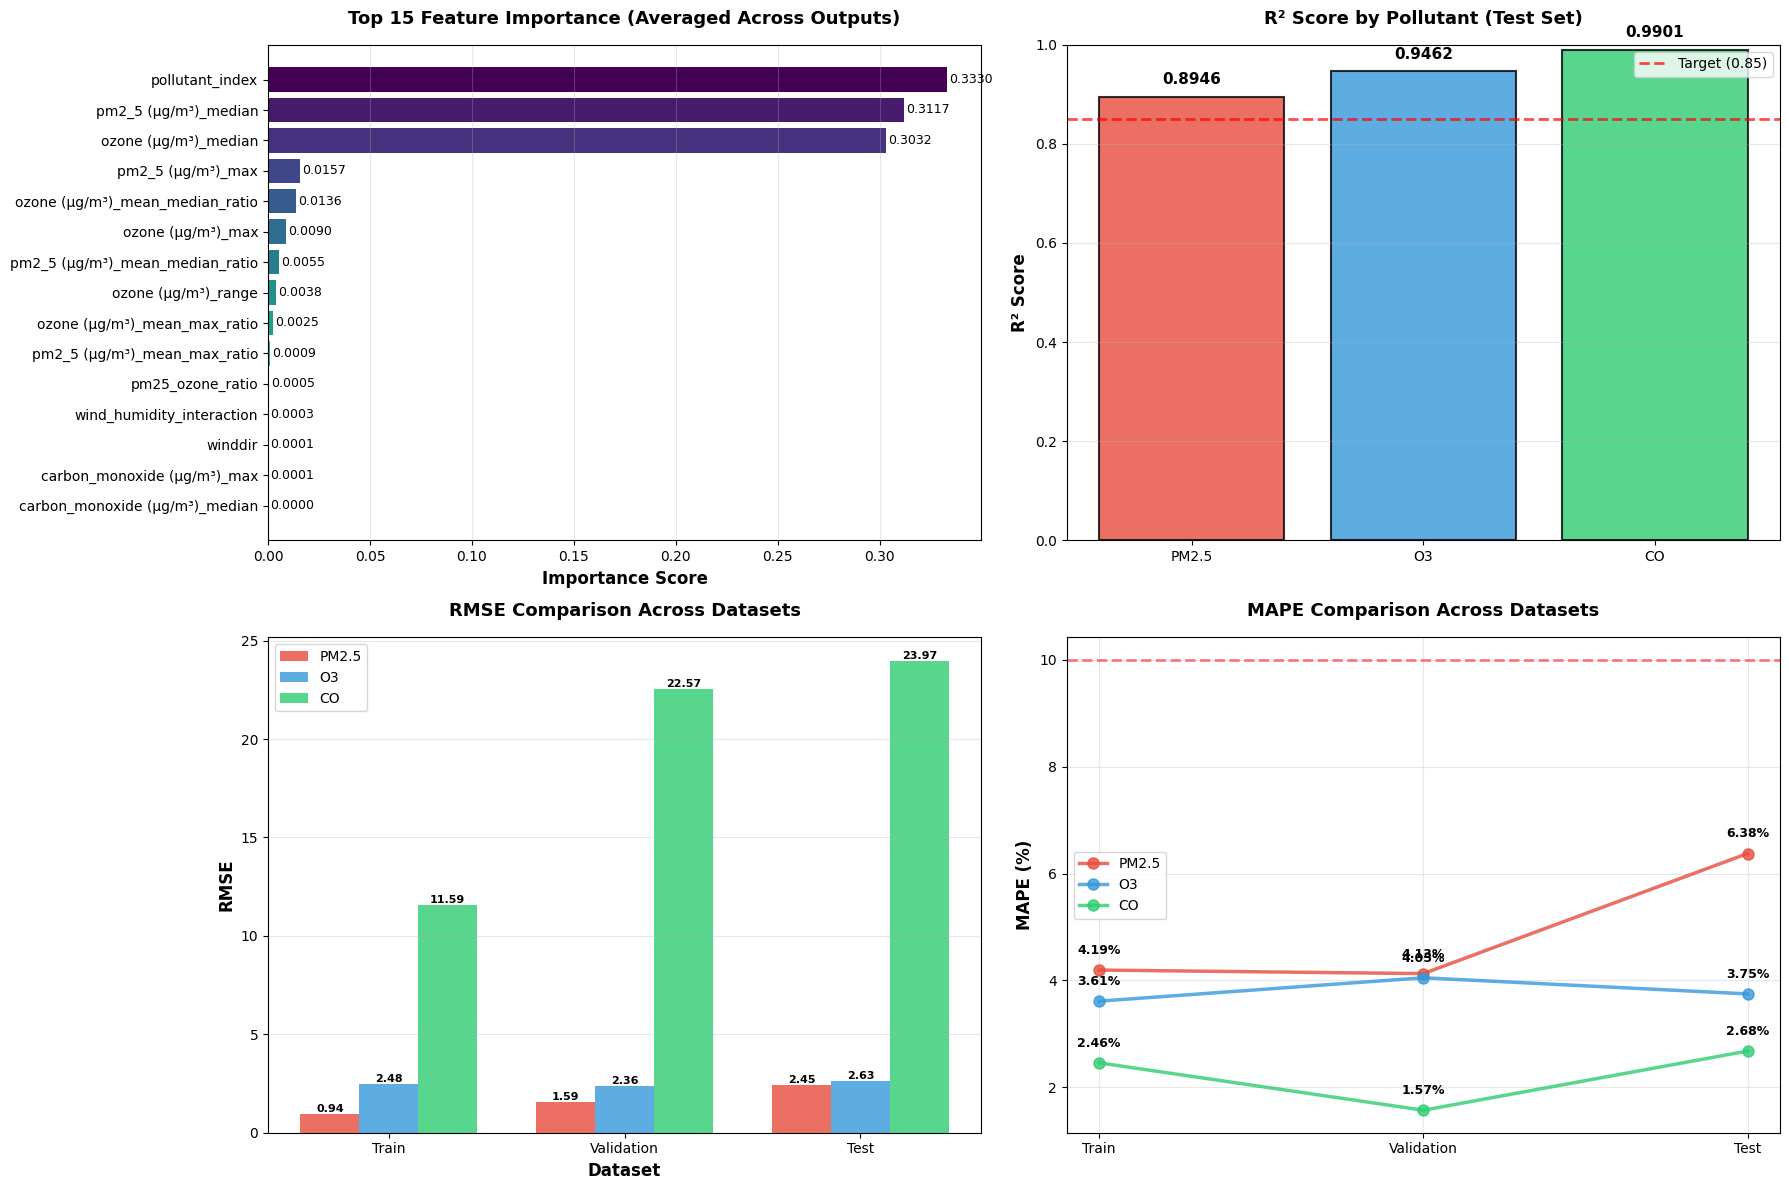

✅ Grafik disimpan: /content/results/decision_tree/dt_actual_vs_predicted.png


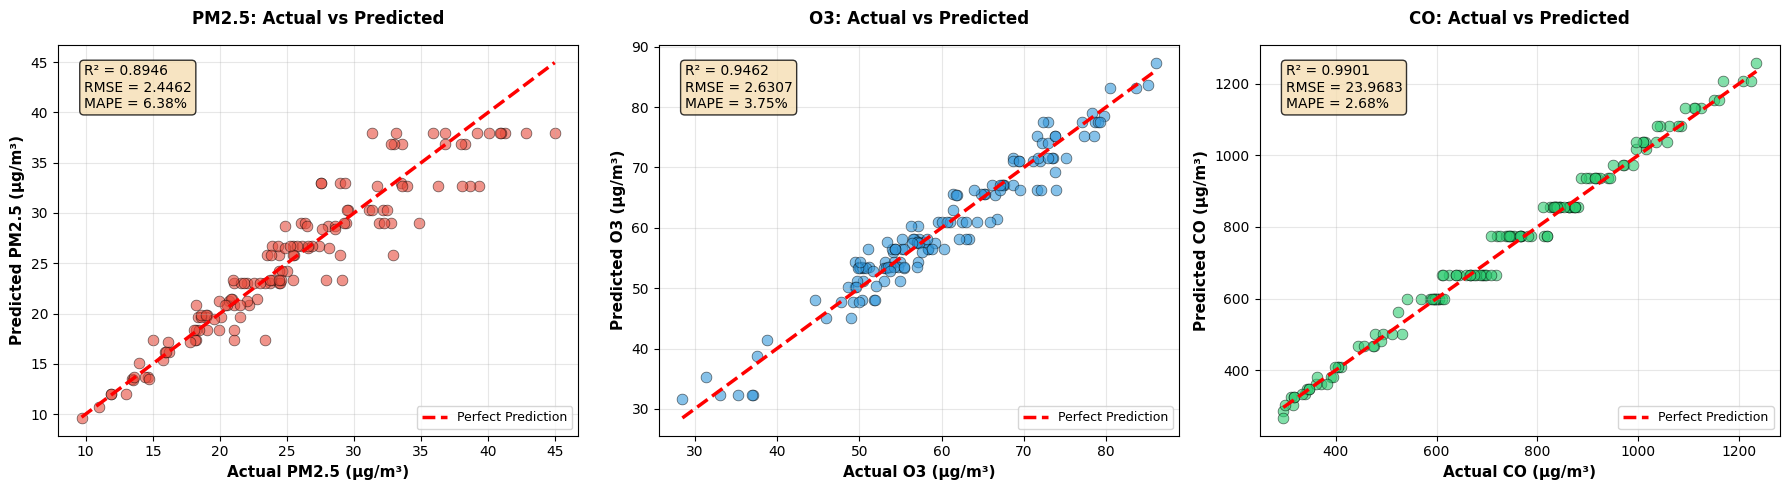

✅ Grafik disimpan: /content/results/decision_tree/dt_timeseries_all_pollutants.png


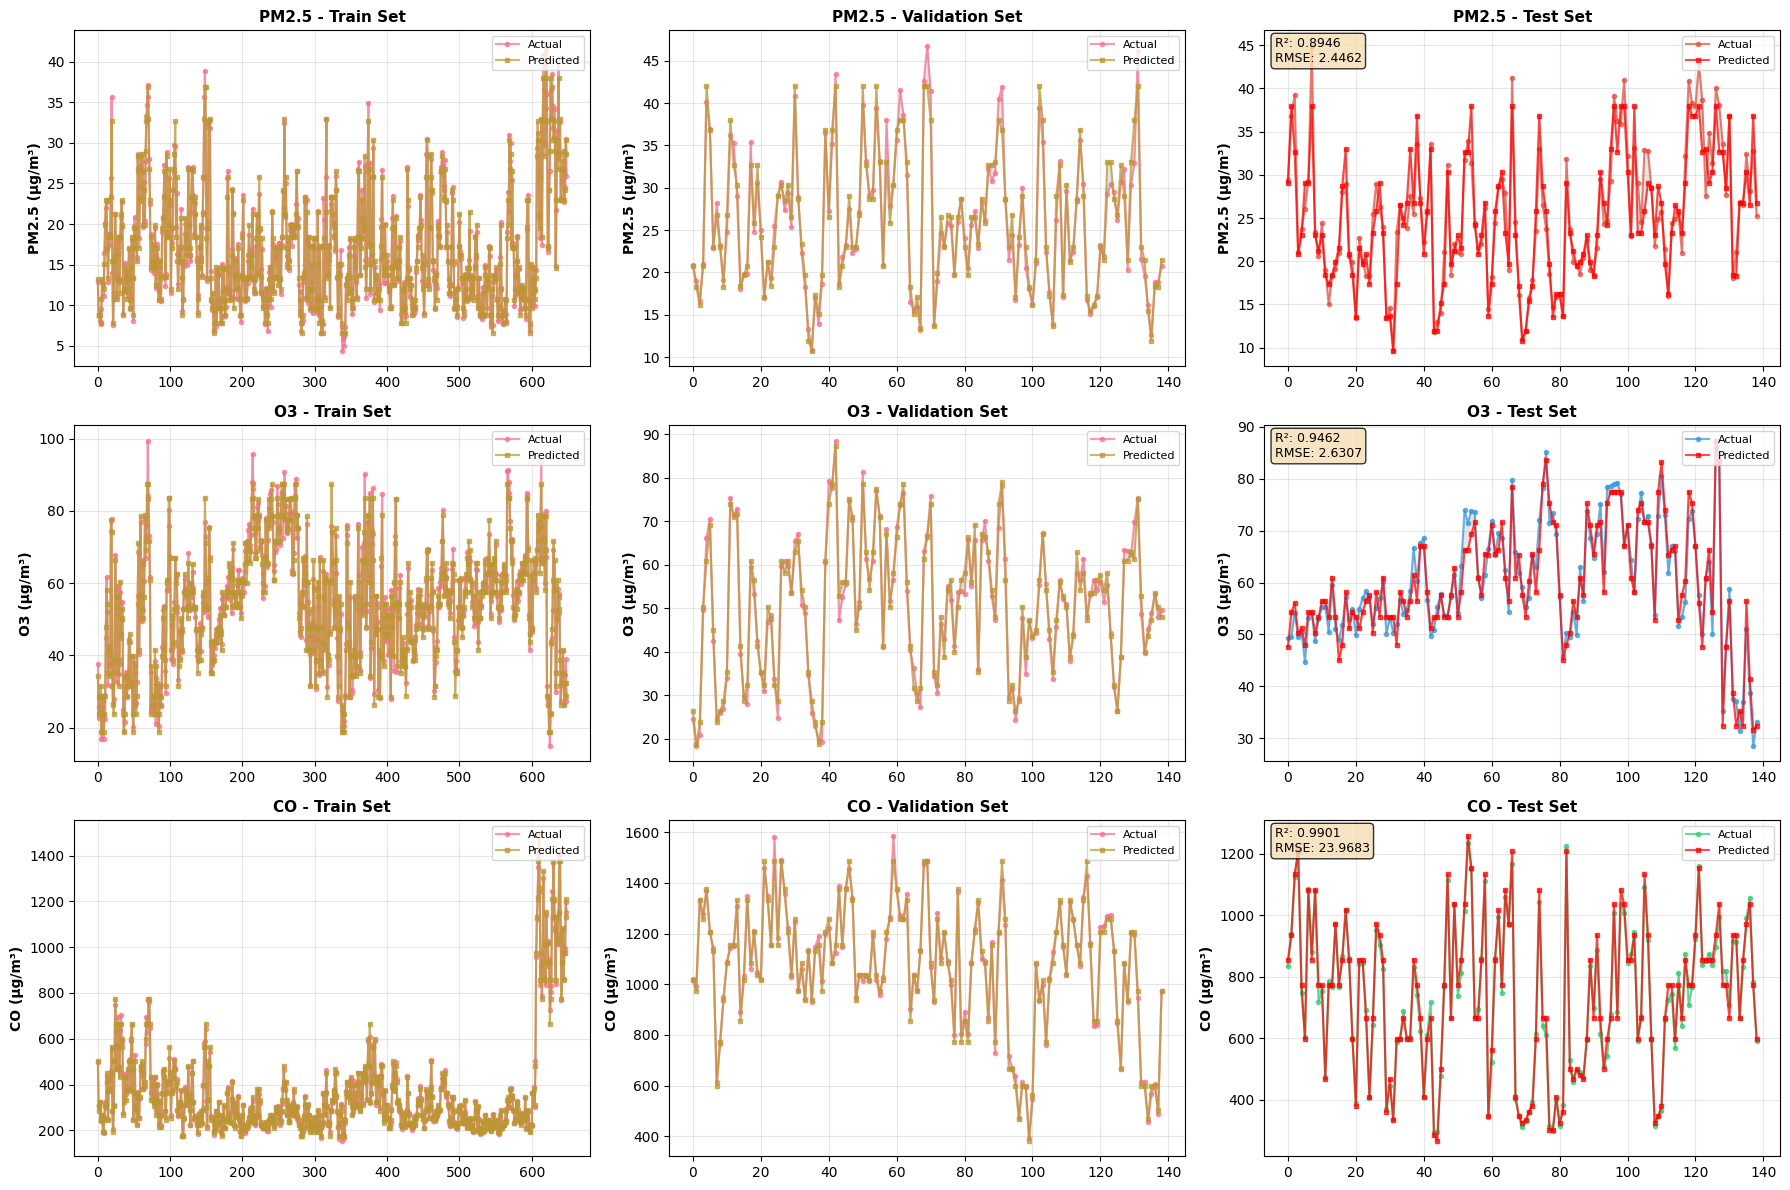

✅ Grafik disimpan: /content/results/decision_tree/dt_residual_analysis.png


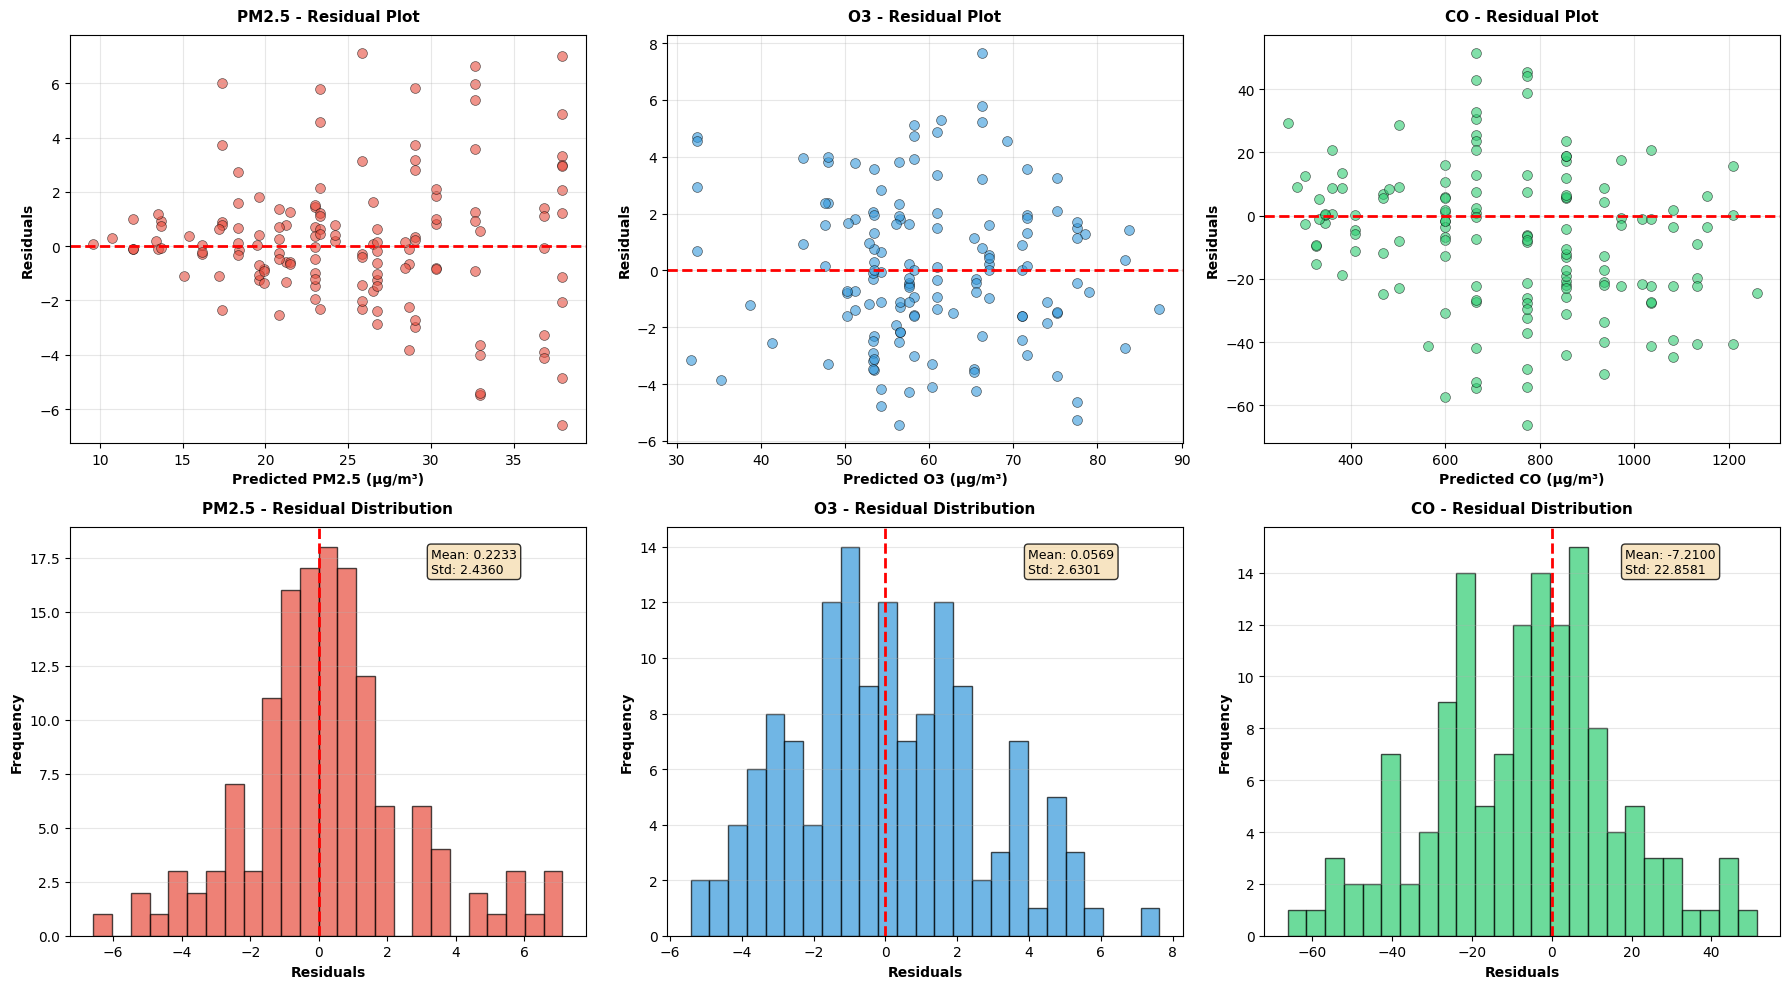

✅ Grafik disimpan: /content/results/decision_tree/dt_metrics_heatmap.png


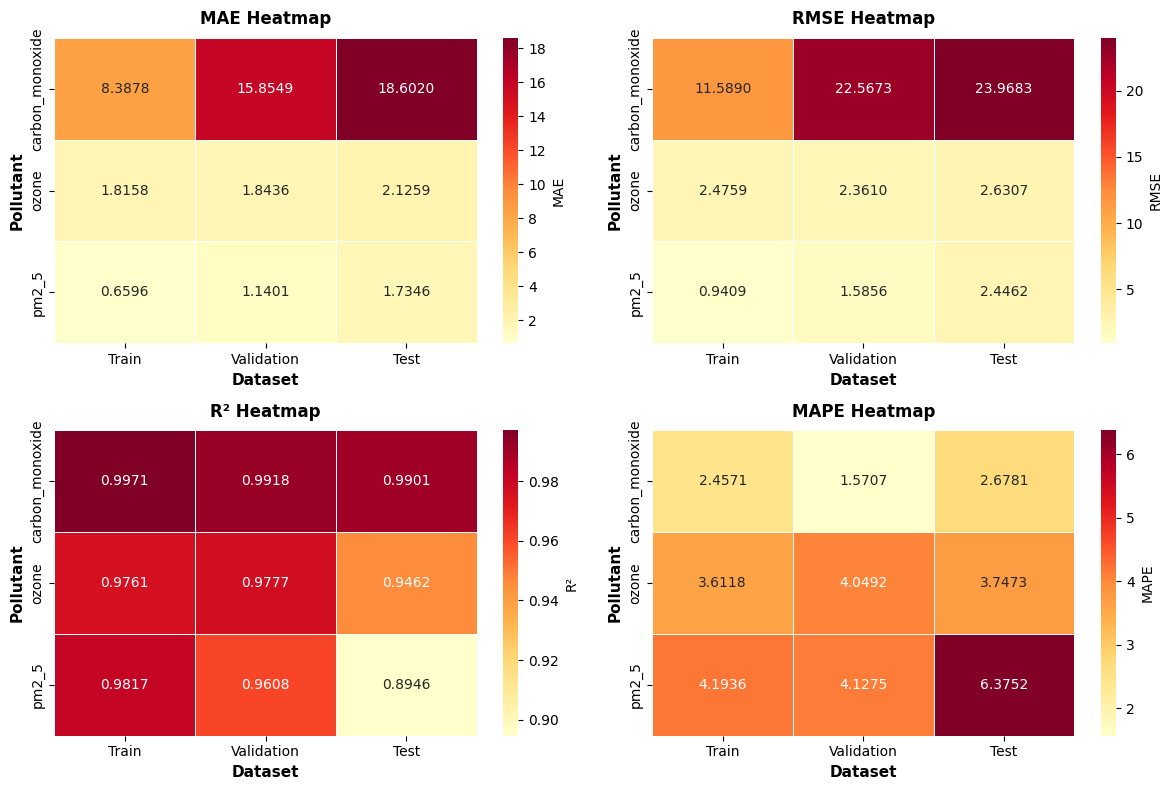

✅ Grafik disimpan: /content/results/decision_tree/dt_overfitting_check.png


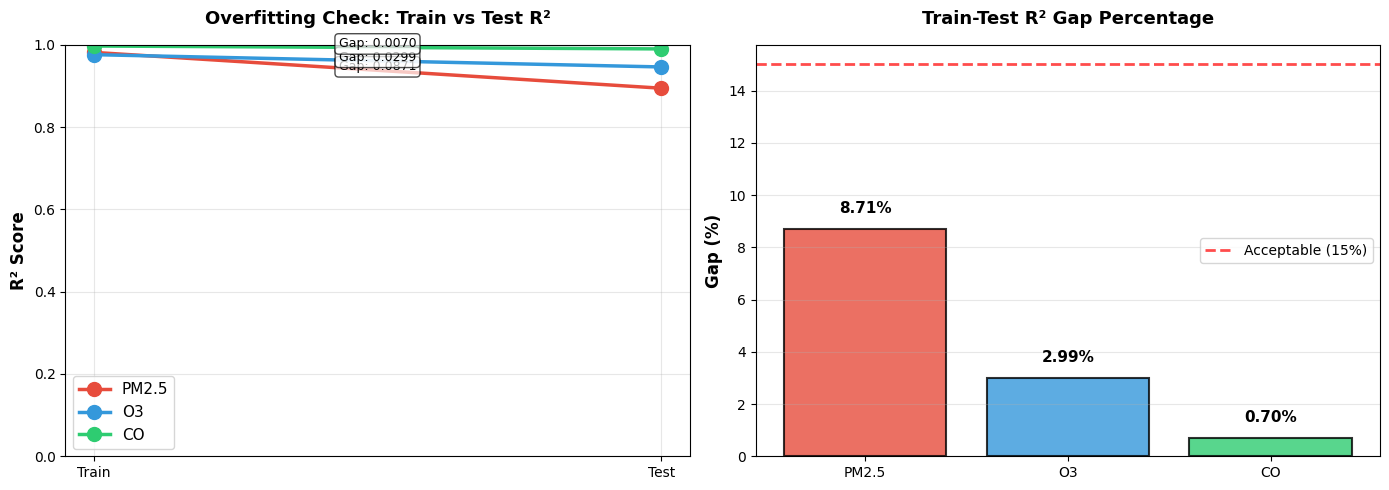


✅ SEMUA GRAFIK DECISION TREE MULTI-OUTPUT BERHASIL DIBUAT!

Grafik yang tersimpan:
1. dt_comprehensive_analysis.png - Overview semua metrik
2. dt_actual_vs_predicted.png - Scatter plot per polutan
3. dt_timeseries_all_pollutants.png - Time series 3 polutan
4. dt_residual_analysis.png - Analisis residual per polutan
5. dt_metrics_heatmap.png - Heatmap metrik
6. dt_overfitting_check.png - Cek overfitting


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path

# Set style
plt.style.use('default')
sns.set_palette("husl")

# Paths
base_dir = Path("/content/results")
dt_dir = base_dir / "decision_tree"

# Load data
predictions = joblib.load(dt_dir / "predictions.pkl")
feature_importance = joblib.load(dt_dir / "feature_importance.pkl")
metrics_df = joblib.load(dt_dir / "metrics.pkl")
metadata = joblib.load(dt_dir / "metadata.pkl")

target_cols = metadata['target_cols']
target_names_display = ['PM2.5', 'O3', 'CO'] # For plot labels
# Derive target names that match the 'Target' column in metrics_df
target_metric_names = [col.split(' ')[0] for col in target_cols]


print("Creating Decision Tree Multi-Output Visualizations...")
print("="*80)

# ==============================================================================
# 1. COMPREHENSIVE ANALYSIS (4 subplots)
# ==============================================================================
fig = plt.figure(figsize=(18, 12))

# 1.1 Feature Importance (Top 15)
ax1 = plt.subplot(2, 2, 1)
top_features = feature_importance.head(15)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
ax1.barh(top_features['Feature'], top_features['Importance'], color=colors)
ax1.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax1.set_title('Top 15 Feature Importance (Averaged Across Outputs)',
              fontsize=13, fontweight='bold', pad=15)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)
for i, v in enumerate(top_features['Importance']):
    ax1.text(v + 0.001, i, f'{v:.4f}', va='center', fontsize=9)

# 1.2 R² Comparison by Target
ax2 = plt.subplot(2, 2, 2)
test_metrics = metrics_df[metrics_df['Dataset'] == 'Test']
x_pos = np.arange(len(target_names_display))
colors_r2 = ['#E74C3C', '#3498DB', '#2ECC71']
bars = ax2.bar(x_pos, test_metrics['R²'].values, color=colors_r2,
               alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(target_names_display)
ax2.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax2.set_title('R² Score by Pollutant (Test Set)', fontsize=13, fontweight='bold', pad=15)
ax2.axhline(y=0.85, color='red', linestyle='--', linewidth=2, label='Target (0.85)', alpha=0.7)
ax2.set_ylim([0, 1.0])
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, test_metrics['R²'].values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{val:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 1.3 RMSE Comparison Across Datasets
ax3 = plt.subplot(2, 2, 3)
datasets = ['Train', 'Validation', 'Test']
x = np.arange(len(datasets))
width = 0.25

for i, (target_display, target_metric, color) in enumerate(zip(target_names_display, target_metric_names, colors_r2)):
    rmse_values = [metrics_df[(metrics_df['Dataset'] == ds) &
                              (metrics_df['Target'] == target_metric)]['RMSE'].values[0]
                   for ds in datasets]
    ax3.bar(x + i*width, rmse_values, width, label=target_display, color=color, alpha=0.8)

    for j, v in enumerate(rmse_values):
        ax3.text(j + i*width, v + 0.1, f'{v:.2f}', ha='center', fontsize=8, fontweight='bold')

ax3.set_xlabel('Dataset', fontsize=12, fontweight='bold')
ax3.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax3.set_title('RMSE Comparison Across Datasets', fontsize=13, fontweight='bold', pad=15)
ax3.set_xticks(x + width)
ax3.set_xticklabels(datasets)
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# 1.4 MAPE Comparison
ax4 = plt.subplot(2, 2, 4)
for i, (target_display, target_metric, color) in enumerate(zip(target_names_display, target_metric_names, colors_r2)):
    mape_values = [metrics_df[(metrics_df['Dataset'] == ds) &
                              (metrics_df['Target'] == target_metric)]['MAPE'].values[0]
                   for ds in datasets]
    ax4.plot(datasets, mape_values, 'o-', label=target_display, color=color,
             linewidth=2.5, markersize=8, alpha=0.8)

    for j, v in enumerate(mape_values):
        ax4.text(j, v + 0.3, f'{v:.2f}%', ha='center', fontsize=9, fontweight='bold')

ax4.set_ylabel('MAPE (%)', fontsize=12, fontweight='bold')
ax4.set_title('MAPE Comparison Across Datasets', fontsize=13, fontweight='bold', pad=15)
ax4.legend(fontsize=10)
ax4.grid(alpha=0.3)
ax4.axhline(y=10, color='red', linestyle='--', linewidth=2, alpha=0.5)

plt.tight_layout()
plt.savefig(dt_dir / 'dt_comprehensive_analysis.png', dpi=300, bbox_inches='tight')
print(f"✅ Grafik disimpan: {dt_dir / 'dt_comprehensive_analysis.png'}")
plt.show()

# ==============================================================================
# 2. ACTUAL VS PREDICTED FOR EACH POLLUTANT (Test Set)
# ==============================================================================
fig2 = plt.figure(figsize=(18, 5))

for i, (target_col, target_name_display, color) in enumerate(zip(target_cols, target_names_display, colors_r2)):
    ax = plt.subplot(1, 3, i+1)

    y_true = predictions['test'][target_col]['y_true']
    y_pred = predictions['test'][target_col]['y_pred']

    ax.scatter(y_true, y_pred, alpha=0.6, s=60, color=color, edgecolors='k', linewidth=0.5)
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            'r--', lw=2.5, label='Perfect Prediction')

    ax.set_xlabel(f'Actual {target_name_display} (μg/m³)', fontsize=11, fontweight='bold')
    ax.set_ylabel(f'Predicted {target_name_display} (μg/m³)', fontsize=11, fontweight='bold')
    ax.set_title(f'{target_name_display}: Actual vs Predicted', fontsize=12, fontweight='bold', pad=15)
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

    # Add metrics
    r2 = predictions['test'][target_col]['R2']
    rmse = predictions['test'][target_col]['RMSE']
    mape = predictions['test'][target_col]['MAPE']

    textstr = f'R² = {r2:.4f}\nRMSE = {rmse:.4f}\nMAPE = {mape:.2f}%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig(dt_dir / 'dt_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
print(f"✅ Grafik disimpan: {dt_dir / 'dt_actual_vs_predicted.png'}")
plt.show()

# ==============================================================================
# 3. TIME SERIES PREDICTION FOR EACH POLLUTANT
# ==============================================================================
fig3 = plt.figure(figsize=(18, 12))

for idx, (target_col, target_name_display, color) in enumerate(zip(target_cols, target_names_display, colors_r2)):
    # Train
    ax1 = plt.subplot(3, 3, idx*3 + 1)
    y_true = predictions['train'][target_col]['y_true']
    y_pred = predictions['train'][target_col]['y_pred']
    indices = np.arange(len(y_true))

    ax1.plot(indices, y_true, 'o-', label='Actual', linewidth=1.5, markersize=3, alpha=0.7)
    ax1.plot(indices, y_pred, 's-', label='Predicted', linewidth=1.5, markersize=3, alpha=0.7)
    ax1.fill_between(indices, y_true, y_pred, alpha=0.2, color='gray')
    ax1.set_ylabel(f'{target_name_display} (μg/m³)', fontsize=10, fontweight='bold')
    ax1.set_title(f'{target_name_display} - Train Set', fontsize=11, fontweight='bold')
    ax1.legend(fontsize=8, loc='upper right')
    ax1.grid(alpha=0.3)

    # Validation
    ax2 = plt.subplot(3, 3, idx*3 + 2)
    y_true = predictions['val'][target_col]['y_true']
    y_pred = predictions['val'][target_col]['y_pred']
    indices = np.arange(len(y_true))

    ax2.plot(indices, y_true, 'o-', label='Actual', linewidth=1.5, markersize=3, alpha=0.7)
    ax2.plot(indices, y_pred, 's-', label='Predicted', linewidth=1.5, markersize=3, alpha=0.7)
    ax2.fill_between(indices, y_true, y_pred, alpha=0.2, color='gray')
    ax2.set_ylabel(f'{target_name_display} (μg/m³)', fontsize=10, fontweight='bold')
    ax2.set_title(f'{target_name_display} - Validation Set', fontsize=11, fontweight='bold')
    ax2.legend(fontsize=8, loc='upper right')
    ax2.grid(alpha=0.3)

    # Test
    ax3 = plt.subplot(3, 3, idx*3 + 3)
    y_true = predictions['test'][target_col]['y_true']
    y_pred = predictions['test'][target_col]['y_pred']
    indices = np.arange(len(y_true))

    ax3.plot(indices, y_true, 'o-', label='Actual', linewidth=1.5, markersize=3, alpha=0.7, color=color)
    ax3.plot(indices, y_pred, 's-', label='Predicted', linewidth=1.5, markersize=3, alpha=0.7, color='red')
    ax3.fill_between(indices, y_true, y_pred, alpha=0.2, color='gray')
    ax3.set_ylabel(f'{target_name_display} (μg/m³)', fontsize=10, fontweight='bold')
    ax3.set_title(f'{target_name_display} - Test Set', fontsize=11, fontweight='bold')
    ax3.legend(fontsize=8, loc='upper right')
    ax3.grid(alpha=0.3)

    # Add metrics to test plot
    r2 = predictions['test'][target_col]['R2']
    rmse = predictions['test'][target_col]['RMSE']
    textstr = f'R²: {r2:.4f}\nRMSE: {rmse:.4f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax3.text(0.02, 0.98, textstr, transform=ax3.transAxes, fontsize=9,
             verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig(dt_dir / 'dt_timeseries_all_pollutants.png', dpi=300, bbox_inches='tight')
print(f"✅ Grafik disimpan: {dt_dir / 'dt_timeseries_all_pollutants.png'}")
plt.show()

# ==============================================================================
# 4. RESIDUAL ANALYSIS FOR EACH POLLUTANT
# ==============================================================================
fig4 = plt.figure(figsize=(18, 10))

for i, (target_col, target_name_display, color) in enumerate(zip(target_cols, target_names_display, colors_r2)):
    y_true = predictions['test'][target_col]['y_true']
    y_pred = predictions['test'][target_col]['y_pred']
    residuals = y_true - y_pred

    # Residual scatter plot
    ax1 = plt.subplot(2, 3, i+1)
    ax1.scatter(y_pred, residuals, alpha=0.6, s=50, color=color, edgecolors='k', linewidth=0.5)
    ax1.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax1.set_xlabel(f'Predicted {target_name_display} (μg/m³)', fontsize=10, fontweight='bold')
    ax1.set_ylabel('Residuals', fontsize=10, fontweight='bold')
    ax1.set_title(f'{target_name_display} - Residual Plot', fontsize=11, fontweight='bold', pad=10)
    ax1.grid(alpha=0.3)

    # Residual histogram
    ax2 = plt.subplot(2, 3, i+4)
    ax2.hist(residuals, bins=25, edgecolor='black', alpha=0.7, color=color)
    ax2.axvline(x=0, color='r', linestyle='--', linewidth=2)
    ax2.set_xlabel('Residuals', fontsize=10, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=10, fontweight='bold')
    ax2.set_title(f'{target_name_display} - Residual Distribution', fontsize=11, fontweight='bold', pad=10)
    ax2.grid(axis='y', alpha=0.3)

    # Add statistics
    mean_res = np.mean(residuals)
    std_res = np.std(residuals)
    textstr = f'Mean: {mean_res:.4f}\nStd: {std_res:.4f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax2.text(0.70, 0.95, textstr, transform=ax2.transAxes, fontsize=9,
             verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig(dt_dir / 'dt_residual_analysis.png', dpi=300, bbox_inches='tight')
print(f"✅ Grafik disimpan: {dt_dir / 'dt_residual_analysis.png'}")
plt.show()

# ==============================================================================
# 5. METRICS HEATMAP
# ==============================================================================
fig5 = plt.figure(figsize=(12, 8))

# Pivot metrics for heatmap
metrics_pivot = metrics_df.pivot_table(
    index='Target',
    columns='Dataset',
    values=['MAE', 'RMSE', 'R²', 'MAPE']
)

# Create subplots for each metric
for idx, metric in enumerate(['MAE', 'RMSE', 'R²', 'MAPE']):
    ax = plt.subplot(2, 2, idx+1)
    data = metrics_pivot[metric][['Train', 'Validation', 'Test']]

    sns.heatmap(data, annot=True, fmt='.4f', cmap='YlOrRd',
                cbar_kws={'label': metric}, ax=ax, linewidths=0.5)
    ax.set_title(f'{metric} Heatmap', fontsize=12, fontweight='bold', pad=10)
    ax.set_ylabel('Pollutant', fontsize=11, fontweight='bold')
    ax.set_xlabel('Dataset', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(dt_dir / 'dt_metrics_heatmap.png', dpi=300, bbox_inches='tight')
print(f"✅ Grafik disimpan: {dt_dir / 'dt_metrics_heatmap.png'}")
plt.show()

# ==============================================================================
# 6. OVERFITTING CHECK VISUALIZATION
# ==============================================================================
fig6 = plt.figure(figsize=(14, 5))

# R² comparison
ax1 = plt.subplot(1, 2, 1)
for target_display, target_metric, color in zip(target_names_display, target_metric_names, colors_r2):
    train_r2 = metrics_df[(metrics_df['Dataset'] == 'Train') &
                          (metrics_df['Target'] == target_metric)]['R²'].values[0]
    test_r2 = metrics_df[(metrics_df['Dataset'] == 'Test') &
                         (metrics_df['Target'] == target_metric)]['R²'].values[0]

    ax1.plot(['Train', 'Test'], [train_r2, test_r2], 'o-',
             label=target_display, color=color, linewidth=2.5, markersize=10)

    gap = train_r2 - test_r2
    mid_point = (train_r2 + test_r2) / 2
    ax1.text(0.5, mid_point, f'Gap: {gap:.4f}', ha='center', fontsize=9,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('Overfitting Check: Train vs Test R²', fontsize=13, fontweight='bold', pad=15)
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)
ax1.set_ylim([0, 1.0])

# Gap percentage
ax2 = plt.subplot(1, 2, 2)
gaps = []
for target_display, target_metric in zip(target_names_display, target_metric_names):
    train_r2 = metrics_df[(metrics_df['Dataset'] == 'Train') &
                          (metrics_df['Target'] == target_metric)]['R²'].values[0]
    test_r2 = metrics_df[(metrics_df['Dataset'] == 'Test') &
                         (metrics_df['Target'] == target_metric)]['R²'].values[0]
    gap_pct = (train_r2 - test_r2) * 100
    gaps.append(gap_pct)

bars = ax2.bar(target_names_display, gaps, color=colors_r2, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.axhline(y=15, color='red', linestyle='--', linewidth=2, label='Acceptable (15%)', alpha=0.7)
ax2.set_ylabel('Gap (%)', fontsize=12, fontweight='bold')
ax2.set_title('Train-Test R² Gap Percentage', fontsize=13, fontweight='bold', pad=15)
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, gaps):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{val:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(dt_dir / 'dt_overfitting_check.png', dpi=300, bbox_inches='tight')
print(f"✅ Grafik disimpan: {dt_dir / 'dt_overfitting_check.png'}")
plt.show()

print("\n" + "="*80)
print("✅ SEMUA GRAFIK DECISION TREE MULTI-OUTPUT BERHASIL DIBUAT!")
print("="*80)
print("\nGrafik yang tersimpan:")
print("1. dt_comprehensive_analysis.png - Overview semua metrik")
print("2. dt_actual_vs_predicted.png - Scatter plot per polutan")
print("3. dt_timeseries_all_pollutants.png - Time series 3 polutan")
print("4. dt_residual_analysis.png - Analisis residual per polutan")
print("5. dt_metrics_heatmap.png - Heatmap metrik")
print("6. dt_overfitting_check.png - Cek overfitting")

In [ ]:
import numpy as np
import pandas as pd
import joblib
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ============================================================================
# CONFIG - ULTRA SIMPLE
# ============================================================================
BASE_DIR = Path("/content/results")
SHARED_DIR = BASE_DIR / "shared_data"
OUT_DIR = BASE_DIR / "gru_v9_simple"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ULTRA MINIMAL CONFIG
BATCH_SIZE = 16  # Small batch for small data
SEQUENCE_LENGTH = 1  # Single day prediction
EPOCHS = 250
SEED = 42
LEARNING_RATE = 5e-4

np.random.seed(SEED)
tf.random.set_seed(SEED)

print("GRU v9 - ULTRA SIMPLIFIED APPROACH")
print("=" * 80)

# ============================================================================
# LOAD DATA
# ============================================================================
print("\n[1/10] Loading data...")
train_df = joblib.load(SHARED_DIR / "train.pkl")
val_df   = joblib.load(SHARED_DIR / "val.pkl")
test_df  = joblib.load(SHARED_DIR / "test.pkl")
print(f"✅ Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# ============================================================================
# IDENTIFY TARGETS
# ============================================================================
print("\n[2/10] Identifying targets...")
def find_target_column(df, keywords):
    for kw in keywords:
        matches = [c for c in df.columns if kw in c.lower() and 'mean' in c.lower()]
        if matches:
            return matches[0]
    for kw in keywords:
        matches = [c for c in df.columns if kw in c.lower()]
        if matches:
            return matches[0]
    return None

t_pm25 = find_target_column(train_df, ['pm2_5', 'pm2.5', 'pm2'])
t_o3   = find_target_column(train_df, ['ozone', 'o3'])
t_co   = find_target_column(train_df, ['carbon_monoxide', 'carbon monoxide', 'co'])

if not (t_pm25 and t_o3 and t_co):
    raise RuntimeError("Could not detect all target columns.")

target_cols = [t_pm25, t_o3, t_co]
print(f"✅ Targets: {target_cols}")

# ============================================================================
# MINIMAL ESSENTIAL FEATURES ONLY
# ============================================================================
print("\n[3/10] Creating minimal essential features...")

def create_minimal_features(df, targets):
    """Only the most essential predictive features"""
    df = df.copy()

    if 'tanggal' in df.columns:
        df['tanggal'] = pd.to_datetime(df['tanggal'])
        df = df.sort_values('tanggal').reset_index(drop=True)

    # ONLY lag 1 (most important)
    for t in targets:
        df[f"{t}_lag1"] = df[t].shift(1)

    # Simple temporal
    if 'tanggal' in df.columns:
        df['day_of_week'] = df['tanggal'].dt.dayofweek
        df['is_weekend'] = (df['tanggal'].dt.dayofweek >= 5).astype(int)

    # Drop NaN
    original_len = len(df)
    df = df.dropna().reset_index(drop=True)
    dropped = original_len - len(df)
    print(f"   Dropped {dropped} rows with NaN")

    return df

train_df = create_minimal_features(train_df, target_cols)
val_df   = create_minimal_features(val_df, target_cols)
test_df  = create_minimal_features(test_df, target_cols)
print("✅ Minimal features created")

# ============================================================================
# PREPARE FEATURES
# ============================================================================
print("\n[4/10] Preparing features...")
exclude_cols = ['tanggal', 'tanggal_waktu']
feature_cols = [c for c in train_df.columns if c not in exclude_cols + target_cols]
print(f"   Total features: {len(feature_cols)}")
print(f"   Features: {feature_cols[:10]}...")  # Show first 10

# ============================================================================
# SIMPLE STANDARDIZATION (No CO transform initially)
# ============================================================================
print("\n[5/10] Simple standardization...")

# Standard scaling for all
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(train_df[feature_cols])
X_val_scaled   = scaler_X.transform(val_df[feature_cols])
X_test_scaled  = scaler_X.transform(test_df[feature_cols])

# Target scaling
scalers_y = {}
y_train_scaled = np.zeros((len(train_df), len(target_cols)), dtype=np.float32)
y_val_scaled   = np.zeros((len(val_df), len(target_cols)), dtype=np.float32)
y_test_scaled  = np.zeros((len(test_df), len(target_cols)), dtype=np.float32)

for i, col in enumerate(target_cols):
    sc = StandardScaler()
    y_train_scaled[:, i] = sc.fit_transform(train_df[[col]]).flatten()
    y_val_scaled[:, i]   = sc.transform(val_df[[col]]).flatten()
    y_test_scaled[:, i]  = sc.transform(test_df[[col]]).flatten()
    scalers_y[col] = sc

print("✅ Scaling complete")

# Print target statistics
print("\n   Target statistics (original scale):")
for col in target_cols:
    vals = train_df[col].values
    print(f"   {col.split()[0]}: mean={vals.mean():.2f}, std={vals.std():.2f}, "
          f"min={vals.min():.2f}, max={vals.max():.2f}")

# ============================================================================
# CREATE SEQUENCES
# ============================================================================
print("\n[6/10] Creating sequences...")
def create_sequences(X, y, seq_len):
    if seq_len == 1:
        # No sequence, just current timestep
        return X.reshape(-1, 1, X.shape[1]).astype(np.float32), y.astype(np.float32)
    Xs, ys = [], []
    for i in range(len(X) - seq_len + 1):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len-1])
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, SEQUENCE_LENGTH)
X_val_seq,   y_val_seq   = create_sequences(X_val_scaled,   y_val_scaled,   SEQUENCE_LENGTH)
X_test_seq,  y_test_seq  = create_sequences(X_test_scaled,  y_test_scaled,  SEQUENCE_LENGTH)

print(f"   X_train: {X_train_seq.shape}, y_train: {y_train_seq.shape}")
print(f"   X_val:   {X_val_seq.shape}, y_val:   {y_val_seq.shape}")
print(f"   X_test:  {X_test_seq.shape}, y_test:  {y_test_seq.shape}")

n_samples = len(X_train_seq)
print(f"\n   📊 Training samples: {n_samples}")

# ============================================================================
# ULTRA SIMPLE MODEL
# ============================================================================
print("\n[7/10] Building ultra simple model...")

def build_simple_model(input_shape, n_targets, lr=LEARNING_RATE):
    """
    Simplest possible model:
    - Single GRU layer (8 units only!)
    - Minimal regularization
    - Direct outputs
    """
    inp = keras.Input(shape=input_shape)

    # Single tiny GRU
    x = layers.GRU(8,
                   return_sequences=False,
                   kernel_regularizer=regularizers.l2(0.01))(inp)

    # Direct outputs (no hidden layer)
    outputs = []
    for i in range(n_targets):
        out = layers.Dense(1, name=f'out_{i}')(x)
        outputs.append(out)

    model = keras.Model(inputs=inp, outputs=outputs)

    # Simple MSE loss (equal weights)
    loss_dict = {f'out_{i}': 'mse' for i in range(n_targets)}
    metrics = {f'out_{i}': ['mae'] for i in range(n_targets)}

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=loss_dict, metrics=metrics)
    return model

model = build_simple_model((SEQUENCE_LENGTH, X_train_seq.shape[2]), len(target_cols))

total_params = model.count_params()
params_per_sample = total_params / n_samples
print(f"\n✅ Simple model built")
print(f"   Total parameters: {total_params:,}")
print(f"   Params/sample ratio: {params_per_sample:.2f}")

if params_per_sample < 1:
    print(f"   ✅ ULTRA MINIMAL ratio (<1)!")
elif params_per_sample < 2:
    print(f"   ✅ EXCELLENT ratio (<2)")
elif params_per_sample < 5:
    print(f"   ✅ GOOD ratio (<5)")
else:
    print(f"   ⚠️  Consider reducing further")

model.summary()

# ============================================================================
# SIMPLE CALLBACKS
# ============================================================================
print("\n[8/10] Setting up callbacks...")
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    )
]

# ============================================================================
# TRAINING
# ============================================================================
print("\n[9/10] Training...")
y_train_list = [y_train_seq[:, i:i+1] for i in range(len(target_cols))]
y_val_list   = [y_val_seq[:, i:i+1]   for i in range(len(target_cols))]

history = model.fit(
    X_train_seq,
    y_train_list,
    validation_data=(X_val_seq, y_val_list),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_list,
    verbose=2
)

# ============================================================================
# EVALUATION
# ============================================================================
print("\n[10/10] Evaluating...")

def inverse_transform_predictions(y_scaled, scalers, target_cols):
    """Inverse transform predictions"""
    y_orig = np.zeros_like(y_scaled, dtype=np.float32)
    for i, col in enumerate(target_cols):
        y_orig[:, i] = scalers[col].inverse_transform(
            y_scaled[:, i:i+1]
        ).flatten()
    return np.clip(y_orig, 0.0, None)

def evaluate_simple(model, X, y_scaled, y_true_orig, set_name):
    """Simple evaluation"""
    preds = model.predict(X, verbose=0)

    # Stack predictions
    if isinstance(preds, list):
        y_pred_scaled = np.column_stack([p.flatten() for p in preds])
    else:
        y_pred_scaled = preds

    # Inverse transform
    y_pred_orig = inverse_transform_predictions(y_pred_scaled, scalers_y, target_cols)

    print(f"\n📊 {set_name} SET")
    print("=" * 70)

    results = {}
    for i, col in enumerate(target_cols):
        y_t = y_true_orig[:, i]
        y_p = y_pred_orig[:, i]

        mae = mean_absolute_error(y_t, y_p)
        rmse = np.sqrt(mean_squared_error(y_t, y_p))
        r2 = r2_score(y_t, y_p)

        # MAPE
        mask = y_t > 0.1
        if mask.sum() > 0:
            mape = np.mean(np.abs((y_t[mask] - y_p[mask]) / y_t[mask])) * 100
        else:
            mape = np.nan

        print(f"{col.split()[0].upper():<20}: MAE={mae:7.2f} | RMSE={rmse:8.2f} | "
              f"R²={r2:7.4f} | MAPE={mape:6.2f}%")

        results[col] = {
            'MAE': float(mae),
            'RMSE': float(rmse),
            'R2': float(r2),
            'MAPE': float(mape),
            'y_true': y_t,
            'y_pred': y_p
        }

    mean_r2 = np.mean([results[col]['R2'] for col in target_cols])
    print(f"\n📈 Mean R²: {mean_r2:.4f}")

    return results, mean_r2

# Get original scale targets for evaluation
y_train_orig = inverse_transform_predictions(y_train_seq, scalers_y, target_cols)
y_val_orig = inverse_transform_predictions(y_val_seq, scalers_y, target_cols)
y_test_orig = inverse_transform_predictions(y_test_seq, scalers_y, target_cols)

train_results, train_r2 = evaluate_simple(model, X_train_seq, y_train_seq, y_train_orig, "TRAIN")
val_results, val_r2 = evaluate_simple(model, X_val_seq, y_val_seq, y_val_orig, "VALIDATION")
test_results, test_r2 = evaluate_simple(model, X_test_seq, y_test_seq, y_test_orig, "TEST")

# ============================================================================
# ANALYSIS
# ============================================================================
print(f"\n🔍 GENERALIZATION ANALYSIS:")
print("=" * 70)
print(f"   Train mean R²:      {train_r2:7.4f}")
print(f"   Validation mean R²: {val_r2:7.4f}")
print(f"   Test mean R²:       {test_r2:7.4f}")

gap_train_test = train_r2 - test_r2
gap_train_val = train_r2 - val_r2
print(f"   Train-Val gap:      {gap_train_val:7.4f}")
print(f"   Train-Test gap:     {gap_train_test:7.4f}")

if test_r2 > 0.3:
    print(f"\n   ✅ GOOD: Test R² > 0.3")
elif test_r2 > 0.15:
    print(f"\n   ⚠️  FAIR: Test R² > 0.15")
elif test_r2 > 0:
    print(f"\n   ⚠️  WEAK: Test R² > 0 (but positive!)")
else:
    print(f"\n   ❌ POOR: Test R² < 0")

print(f"\n📊 Per-Target Results:")
for col in target_cols:
    tr = train_results[col]['R2']
    vr = val_results[col]['R2']
    te = test_results[col]['R2']
    print(f"   {col.split()[0].upper():<15}: Train={tr:6.4f}, Val={vr:6.4f}, Test={te:6.4f}")

# ============================================================================
# SAVE
# ============================================================================
print("\n[FINAL] Saving artifacts...")
model.save(str(OUT_DIR / "model_v9.keras"))
joblib.dump(scaler_X, OUT_DIR / "scaler_X.pkl")
joblib.dump(scalers_y, OUT_DIR / "scalers_y.pkl")
joblib.dump(feature_cols, OUT_DIR / "features.pkl")
joblib.dump(target_cols, OUT_DIR / "targets.pkl")

joblib.dump({
    'train': train_results,
    'val': val_results,
    'test': test_results
}, OUT_DIR / "results.pkl")

# Save training history
joblib.dump(history.history, OUT_DIR / "history.pkl")

metadata = {
    'version': 'v9_ultra_simple',
    'params': {
        'sequence_length': SEQUENCE_LENGTH,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'gru_units': 8,
        'total_params': int(total_params),
        'params_per_sample': float(params_per_sample)
    },
    'performance': {
        'train_r2': float(train_r2),
        'val_r2': float(val_r2),
        'test_r2': float(test_r2),
        'gap': float(gap_train_test)
    },
    'approach': 'Ultra minimal - just lag1 + temporal features, tiny GRU, no complex transforms'
}
joblib.dump(metadata, OUT_DIR / "metadata.pkl")

print("✅ Complete!")
print("=" * 80)

GRU v9 - ULTRA SIMPLIFIED APPROACH

[1/10] Loading data...
✅ Train: 631, Val: 135, Test: 135

[2/10] Identifying targets...
✅ Targets: ['pm2_5 (μg/m³)_mean', 'ozone (μg/m³)_mean', 'carbon_monoxide (μg/m³)_mean']

[3/10] Creating minimal essential features...
   Dropped 1 rows with NaN
   Dropped 1 rows with NaN
   Dropped 1 rows with NaN
✅ Minimal features created

[4/10] Preparing features...
   Total features: 26
   Features: ['pm2_5 (μg/m³)_max', 'pm2_5 (μg/m³)_median', 'carbon_monoxide (μg/m³)_max', 'carbon_monoxide (μg/m³)_median', 'ozone (μg/m³)_max', 'ozone (μg/m³)_median', 'tempmax', 'tempmin', 'temp', 'humidity']...

[5/10] Simple standardization...
✅ Scaling complete

   Target statistics (original scale):
   pm2_5: mean=16.62, std=6.76, min=4.37, max=40.88
   ozone: mean=54.66, std=15.75, min=14.92, max=95.67
   carbon_monoxide: mean=351.01, std=201.17, min=153.75, max=1487.08

[6/10] Creating sequences...
   X_train: (630, 1, 26), y_train: (630, 3)
   X_val:   (134, 1, 26),

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 1, 26)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_16 (GRU)        │ (None, 8)         │        864 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out_0 (Dense)       │ (None, 1)         │          9 │ gru_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out_1 (Dense)       │ (None, 1)         │          9 │ gru_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out_2 (Dense)       │ (None, 1)         │          9 │ gru_16[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 891 (3.48 KB)

 Trainable params: 891 (3.48 KB)

 Non-trainable params: 0 (0.00 B)


[8/10] Setting up callbacks...

[9/10] Training...
Epoch 1/250
40/40 - 5s - 125ms/step - loss: 3.6161 - out_0_loss: 1.1374 - out_0_mae: 0.8275 - out_1_loss: 1.2811 - out_1_mae: 0.9118 - out_2_loss: 0.9357 - out_2_mae: 0.6031 - val_loss: 15.2856 - val_out_0_loss: 3.8584 - val_out_0_mae: 1.6834 - val_out_1_loss: 1.4448 - val_out_1_mae: 1.0310 - val_out_2_loss: 9.2067 - val_out_2_mae: 2.8912 - learning_rate: 5.0000e-04
Epoch 2/250
40/40 - 0s - 7ms/step - loss: 3.1815 - out_0_loss: 1.0064 - out_0_mae: 0.7680 - out_1_loss: 1.1105 - out_1_mae: 0.8447 - out_2_loss: 0.8206 - out_2_mae: 0.5538 - val_loss: 14.2166 - val_out_0_loss: 3.5195 - val_out_0_mae: 1.5909 - val_out_1_loss: 1.4417 - val_out_1_mae: 1.0335 - val_out_2_loss: 8.5302 - val_out_2_mae: 2.7853 - learning_rate: 5.0000e-04
Epoch 3/250
40/40 - 0s - 6ms/step - loss: 2.8237 - out_0_loss: 0.8935 - out_0_mae: 0.7148 - out_1_loss: 0.9762 - out_1_mae: 0.7887 - out_2_loss: 0.7249 - out_2_mae: 0.5181 - val_loss: 13.1694 - val_out_0_loss: 3.

✅ Scatter plot saved: gru_predictions_scatter.png


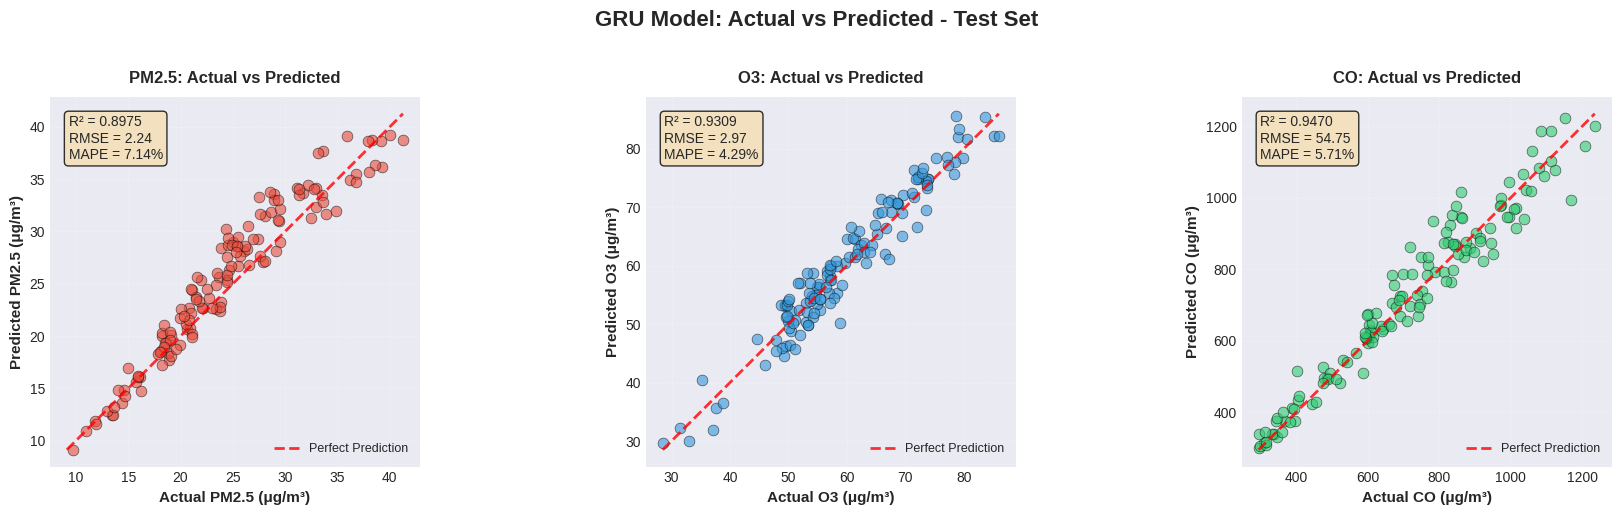

✅ Training history plot saved: gru_training_history.png


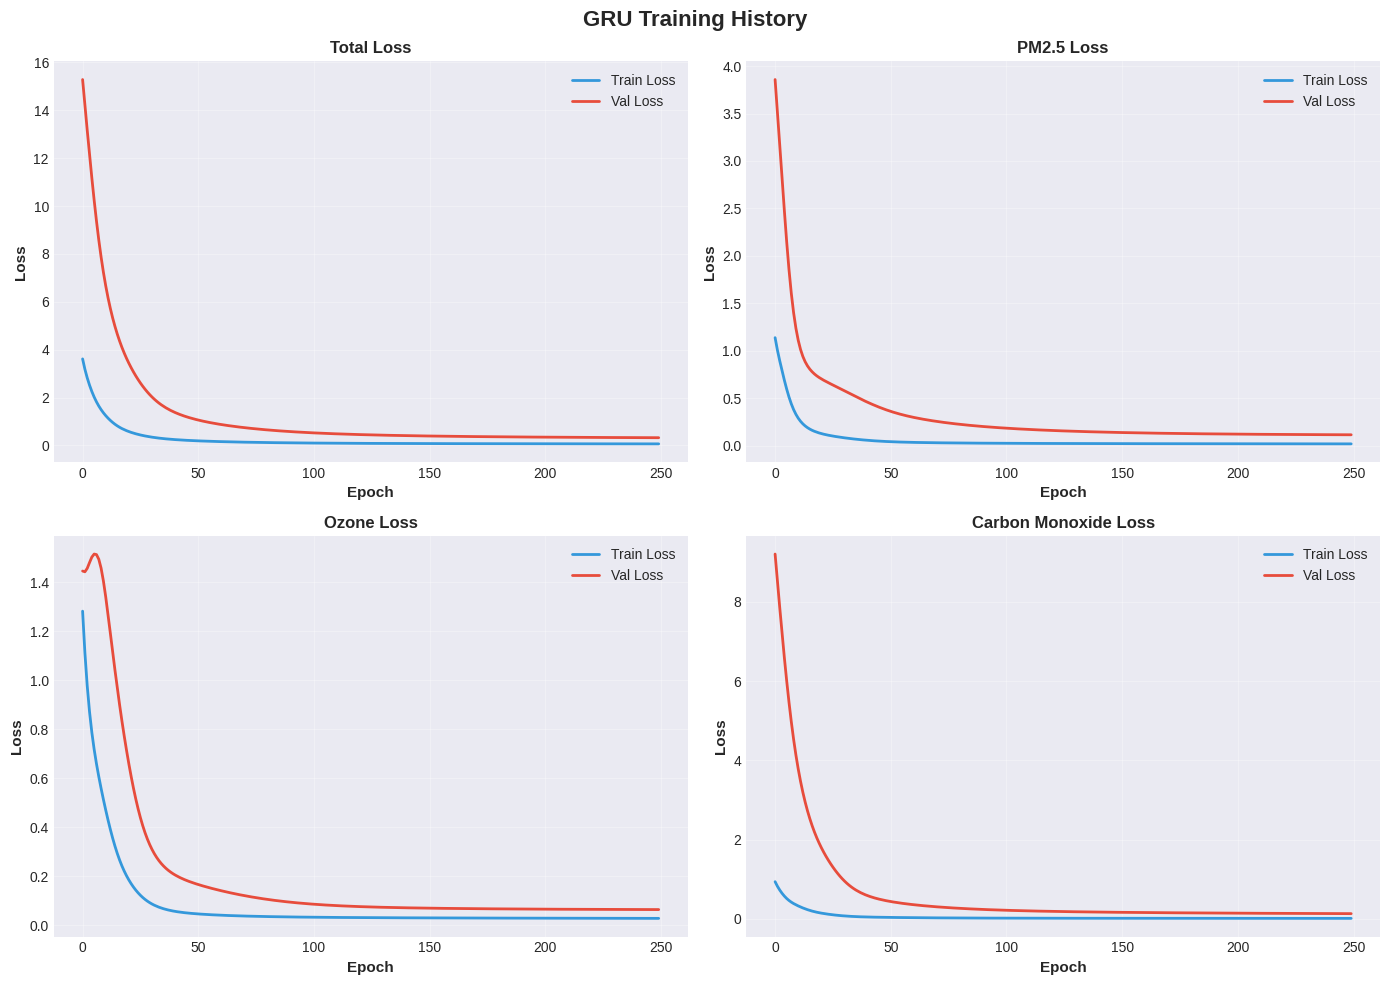

✅ Residual plot saved: gru_residuals.png


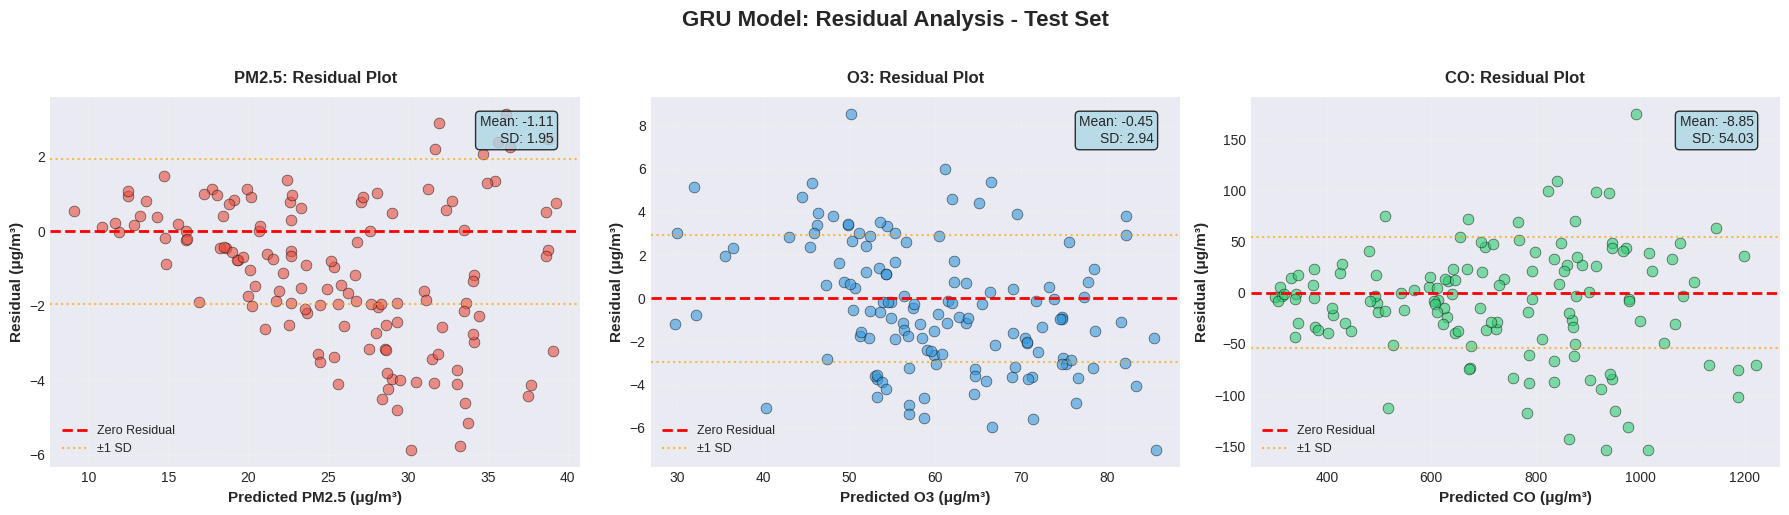


✅ All GRU visualizations complete!


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib
from pathlib import Path

# Load hasil prediksi GRU
BASE_DIR = Path("/content/results")
GRU_DIR = BASE_DIR / "gru_v9_simple"

results = joblib.load(GRU_DIR / "results.pkl")
target_cols = joblib.load(GRU_DIR / "targets.pkl")

# Extract test results
test_results = results['test']

# Setup plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('GRU Model: Actual vs Predicted - Test Set', fontsize=16, fontweight='bold', y=1.02)

# Color mapping
colors = ['#E74C3C', '#3498DB', '#2ECC71']  # Red, Blue, Green
pollutant_names = ['PM2.5', 'O3', 'CO']

for idx, (col, ax, color, name) in enumerate(zip(target_cols, axes, colors, pollutant_names)):
    y_true = test_results[col]['y_true']
    y_pred = test_results[col]['y_pred']

    # Scatter plot
    ax.scatter(y_true, y_pred, alpha=0.6, s=60, color=color, edgecolors='black', linewidth=0.5)

    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction', alpha=0.8)

    # Metrics
    r2 = test_results[col]['R2']
    rmse = test_results[col]['RMSE']
    mape = test_results[col]['MAPE']

    # Add metrics text box
    textstr = f'R² = {r2:.4f}\nRMSE = {rmse:.2f}\nMAPE = {mape:.2f}%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

    # Labels and title
    unit = '(μg/m³)'
    ax.set_xlabel(f'Actual {name} {unit}', fontsize=11, fontweight='bold')
    ax.set_ylabel(f'Predicted {name} {unit}', fontsize=11, fontweight='bold')
    ax.set_title(f'{name}: Actual vs Predicted', fontsize=12, fontweight='bold', pad=10)

    # Grid
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    ax.legend(loc='lower right', fontsize=9)

    # Equal aspect ratio
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig(GRU_DIR / 'gru_predictions_scatter.png', dpi=300, bbox_inches='tight')
print("✅ Scatter plot saved: gru_predictions_scatter.png")
plt.show()

# ============================================================================
# TRAINING HISTORY PLOT
# ============================================================================
history = joblib.load(GRU_DIR / "history.pkl")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('GRU Training History', fontsize=16, fontweight='bold')

# Plot 1: Total Loss
ax1 = axes[0, 0]
ax1.plot(history['loss'], label='Train Loss', linewidth=2, color='#3498DB')
ax1.plot(history['val_loss'], label='Val Loss', linewidth=2, color='#E74C3C')
ax1.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=11, fontweight='bold')
ax1.set_title('Total Loss', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: PM2.5 Loss
ax2 = axes[0, 1]
ax2.plot(history['out_0_loss'], label='Train Loss', linewidth=2, color='#3498DB')
ax2.plot(history['val_out_0_loss'], label='Val Loss', linewidth=2, color='#E74C3C')
ax2.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=11, fontweight='bold')
ax2.set_title('PM2.5 Loss', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Ozone Loss
ax3 = axes[1, 0]
ax3.plot(history['out_1_loss'], label='Train Loss', linewidth=2, color='#3498DB')
ax3.plot(history['val_out_1_loss'], label='Val Loss', linewidth=2, color='#E74C3C')
ax3.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax3.set_ylabel('Loss', fontsize=11, fontweight='bold')
ax3.set_title('Ozone Loss', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Plot 4: CO Loss
ax4 = axes[1, 1]
ax4.plot(history['out_2_loss'], label='Train Loss', linewidth=2, color='#3498DB')
ax4.plot(history['val_out_2_loss'], label='Val Loss', linewidth=2, color='#E74C3C')
ax4.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax4.set_ylabel('Loss', fontsize=11, fontweight='bold')
ax4.set_title('Carbon Monoxide Loss', fontsize=12, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(GRU_DIR / 'gru_training_history.png', dpi=300, bbox_inches='tight')
print("✅ Training history plot saved: gru_training_history.png")
plt.show()

# ============================================================================
# RESIDUAL PLOT
# ============================================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('GRU Model: Residual Analysis - Test Set', fontsize=16, fontweight='bold', y=1.02)

for idx, (col, ax, color, name) in enumerate(zip(target_cols, axes, colors, pollutant_names)):
    y_true = test_results[col]['y_true']
    y_pred = test_results[col]['y_pred']
    residuals = y_true - y_pred

    # Residual scatter
    ax.scatter(y_pred, residuals, alpha=0.6, s=60, color=color, edgecolors='black', linewidth=0.5)
    ax.axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Residual')

    # Add std bands
    std_residual = np.std(residuals)
    ax.axhline(y=std_residual, color='orange', linestyle=':', linewidth=1.5, alpha=0.7, label=f'±1 SD')
    ax.axhline(y=-std_residual, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)

    # Labels
    unit = '(μg/m³)'
    ax.set_xlabel(f'Predicted {name} {unit}', fontsize=11, fontweight='bold')
    ax.set_ylabel(f'Residual {unit}', fontsize=11, fontweight='bold')
    ax.set_title(f'{name}: Residual Plot', fontsize=12, fontweight='bold', pad=10)

    # Stats text
    mean_res = np.mean(residuals)
    textstr = f'Mean: {mean_res:.2f}\nSD: {std_residual:.2f}'
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
    ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right', bbox=props)

    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    ax.legend(loc='lower left', fontsize=9)

plt.tight_layout()
plt.savefig(GRU_DIR / 'gru_residuals.png', dpi=300, bbox_inches='tight')
print("✅ Residual plot saved: gru_residuals.png")
plt.show()

print("\n✅ All GRU visualizations complete!")

Model: "cnn_multihead"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_grid          │ (None, 15, 15, 7) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 15, 15,    │      2,048 │ input_grid[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 15, 15,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 7, 7, 64)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d   │ (None, 7, 7, 64)  │          0 │ max_pooling2d[0]… │
│ (SpatialDropout2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7, 128) │     73,856 │ spatial_dropout2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 128) │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 3, 3, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_1 │ (None, 3, 3, 128) │          0 │ max_pooling2d_1[… │
│ (SpatialDropout2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 3, 3, 256) │    295,168 │ spatial_dropout2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 3, 256) │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 3, 3, 128) │    295,040 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 6, 6, 64)  │     73,792 │ conv2d_4[0][0]    │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 6, 64)  │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 820,358 (3.13 MB)

 Trainable params: 819,334 (3.13 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/120
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - heatmap_out_loss: 0.0622 - loss: 6.3285 - reg_out_loss: 3.4058
Epoch 1: val_loss improved from inf to 16.25082, saving model to /content/results/cnn_multihead_fixed/best_cnn.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - heatmap_out_loss: 0.0606 - loss: 6.3015 - reg_out_loss: 3.3819 - val_heatmap_out_loss: 0.0134 - val_loss: 16.2508 - val_reg_out_loss: 13.2093 - learning_rate: 5.0000e-04
Epoch 2/120
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - heatmap_out_loss: 0.0058 - loss: 5.0876 - reg_out_loss: 2.2687
Epoch 2: val_loss improved from 16.25082 to 14.05260, saving model to /content/results/cnn_multihead_fixed/best_cnn.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - heatmap_out_loss: 0.0058 - loss: 5.0779 - reg_out_loss: 2.2604 - val_heatmap_out_loss: 0.0120 - val_loss: 14.0526 - val_reg_out_loss: 11.0850 - learning_rate: 5.0000e-04
Epoch 3/120
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - heatmap_out_loss: 0.0051 - loss: 4.2657 - reg_

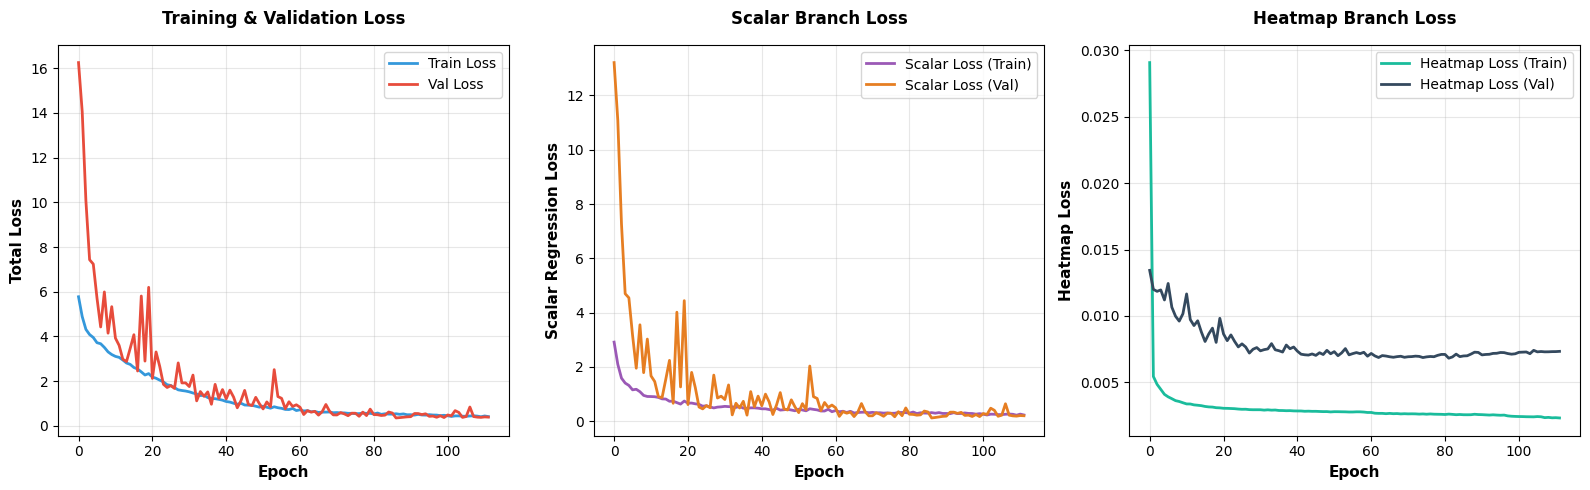

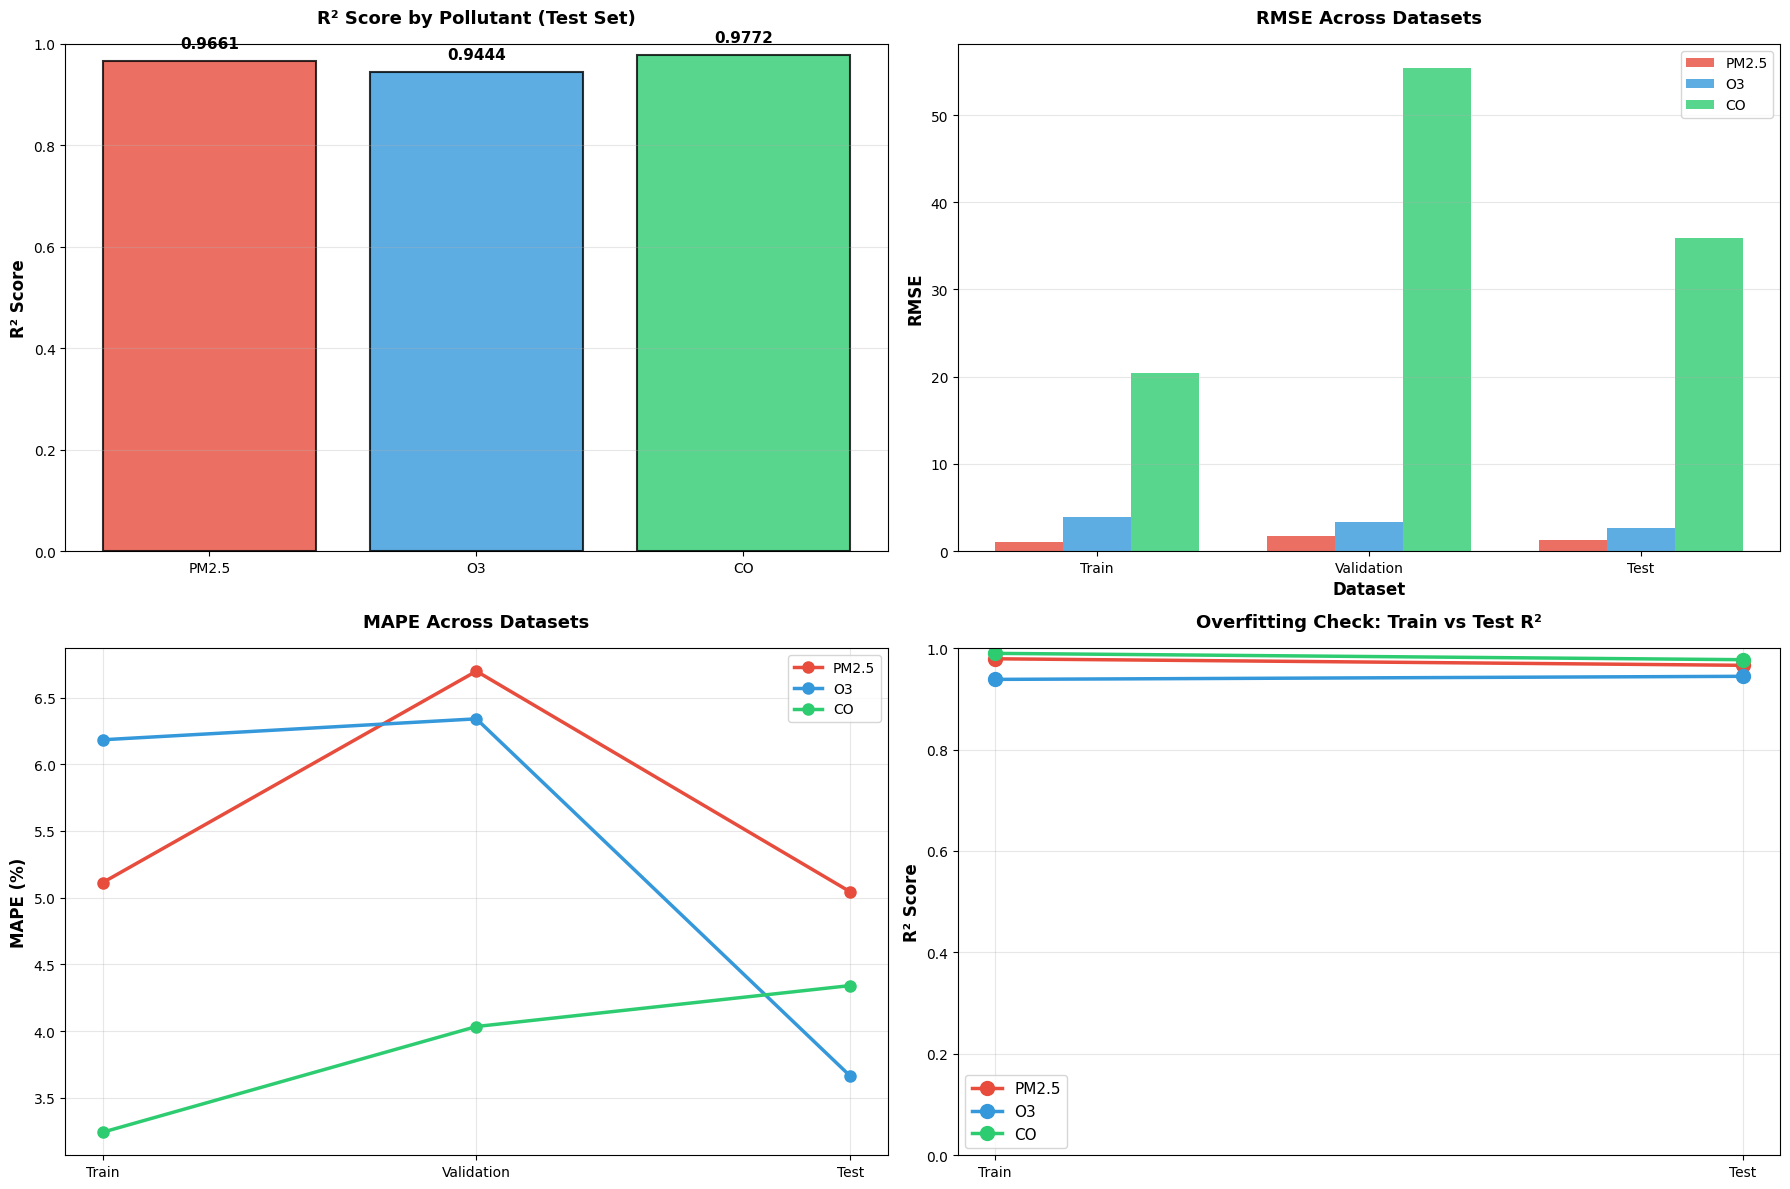

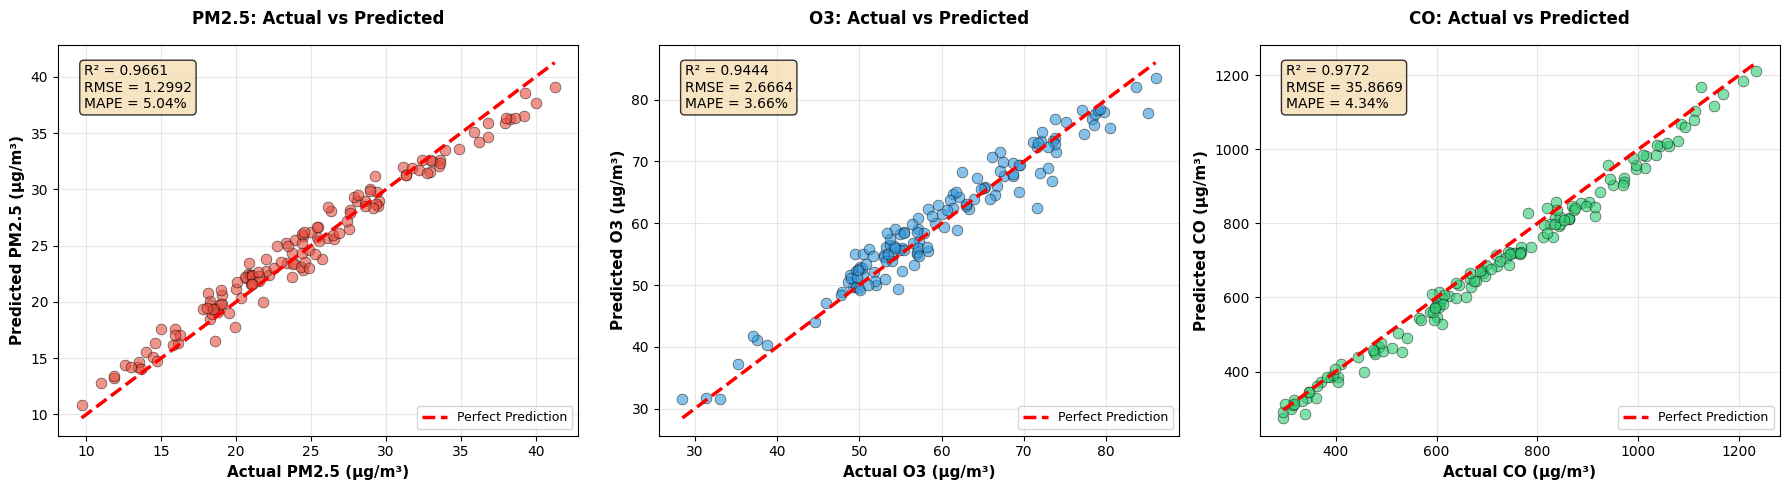

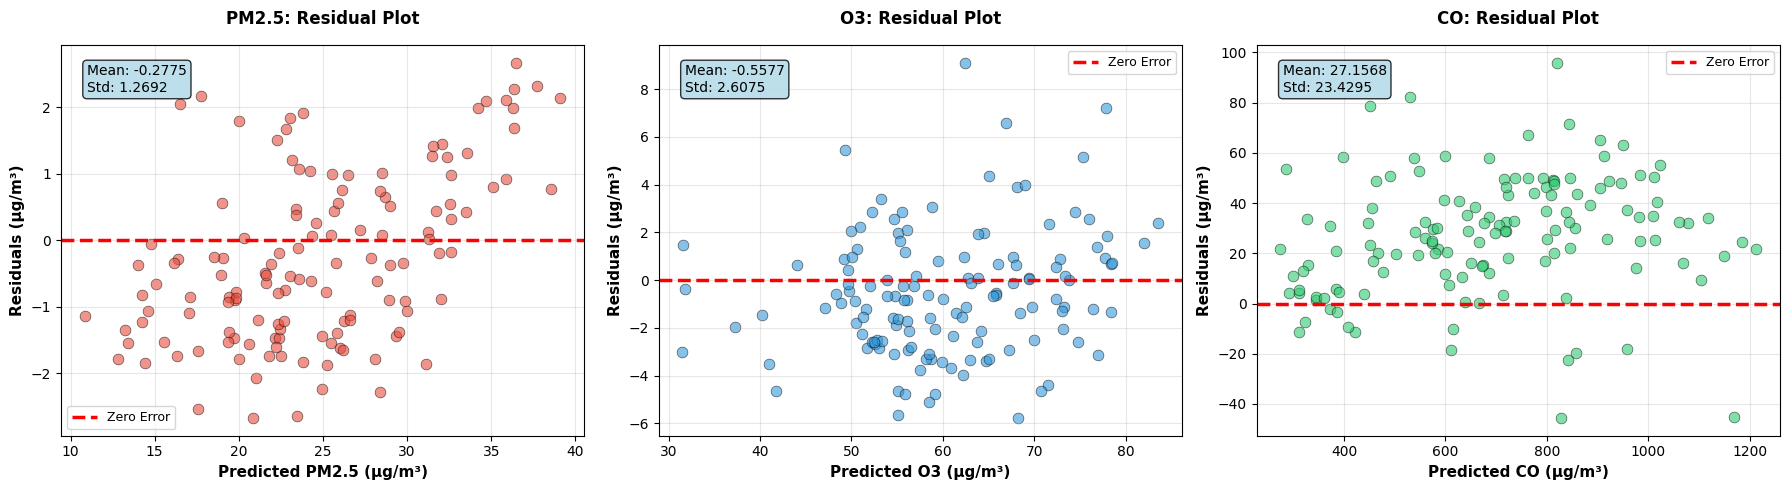

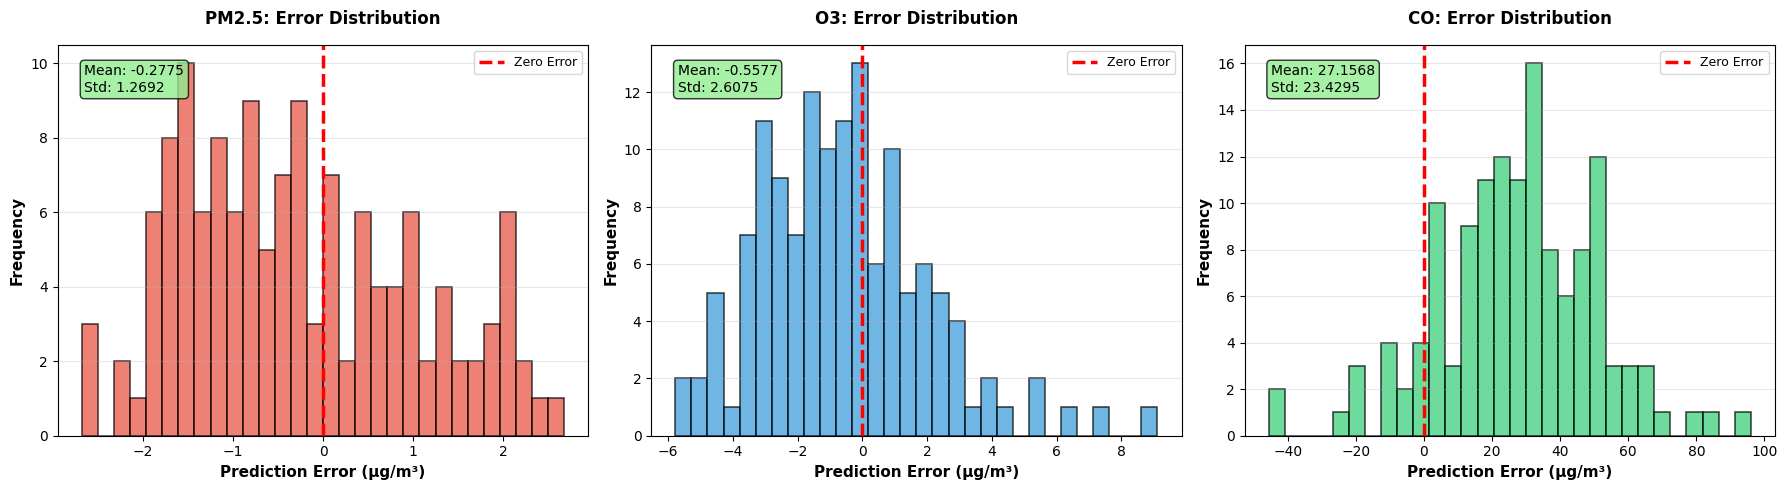

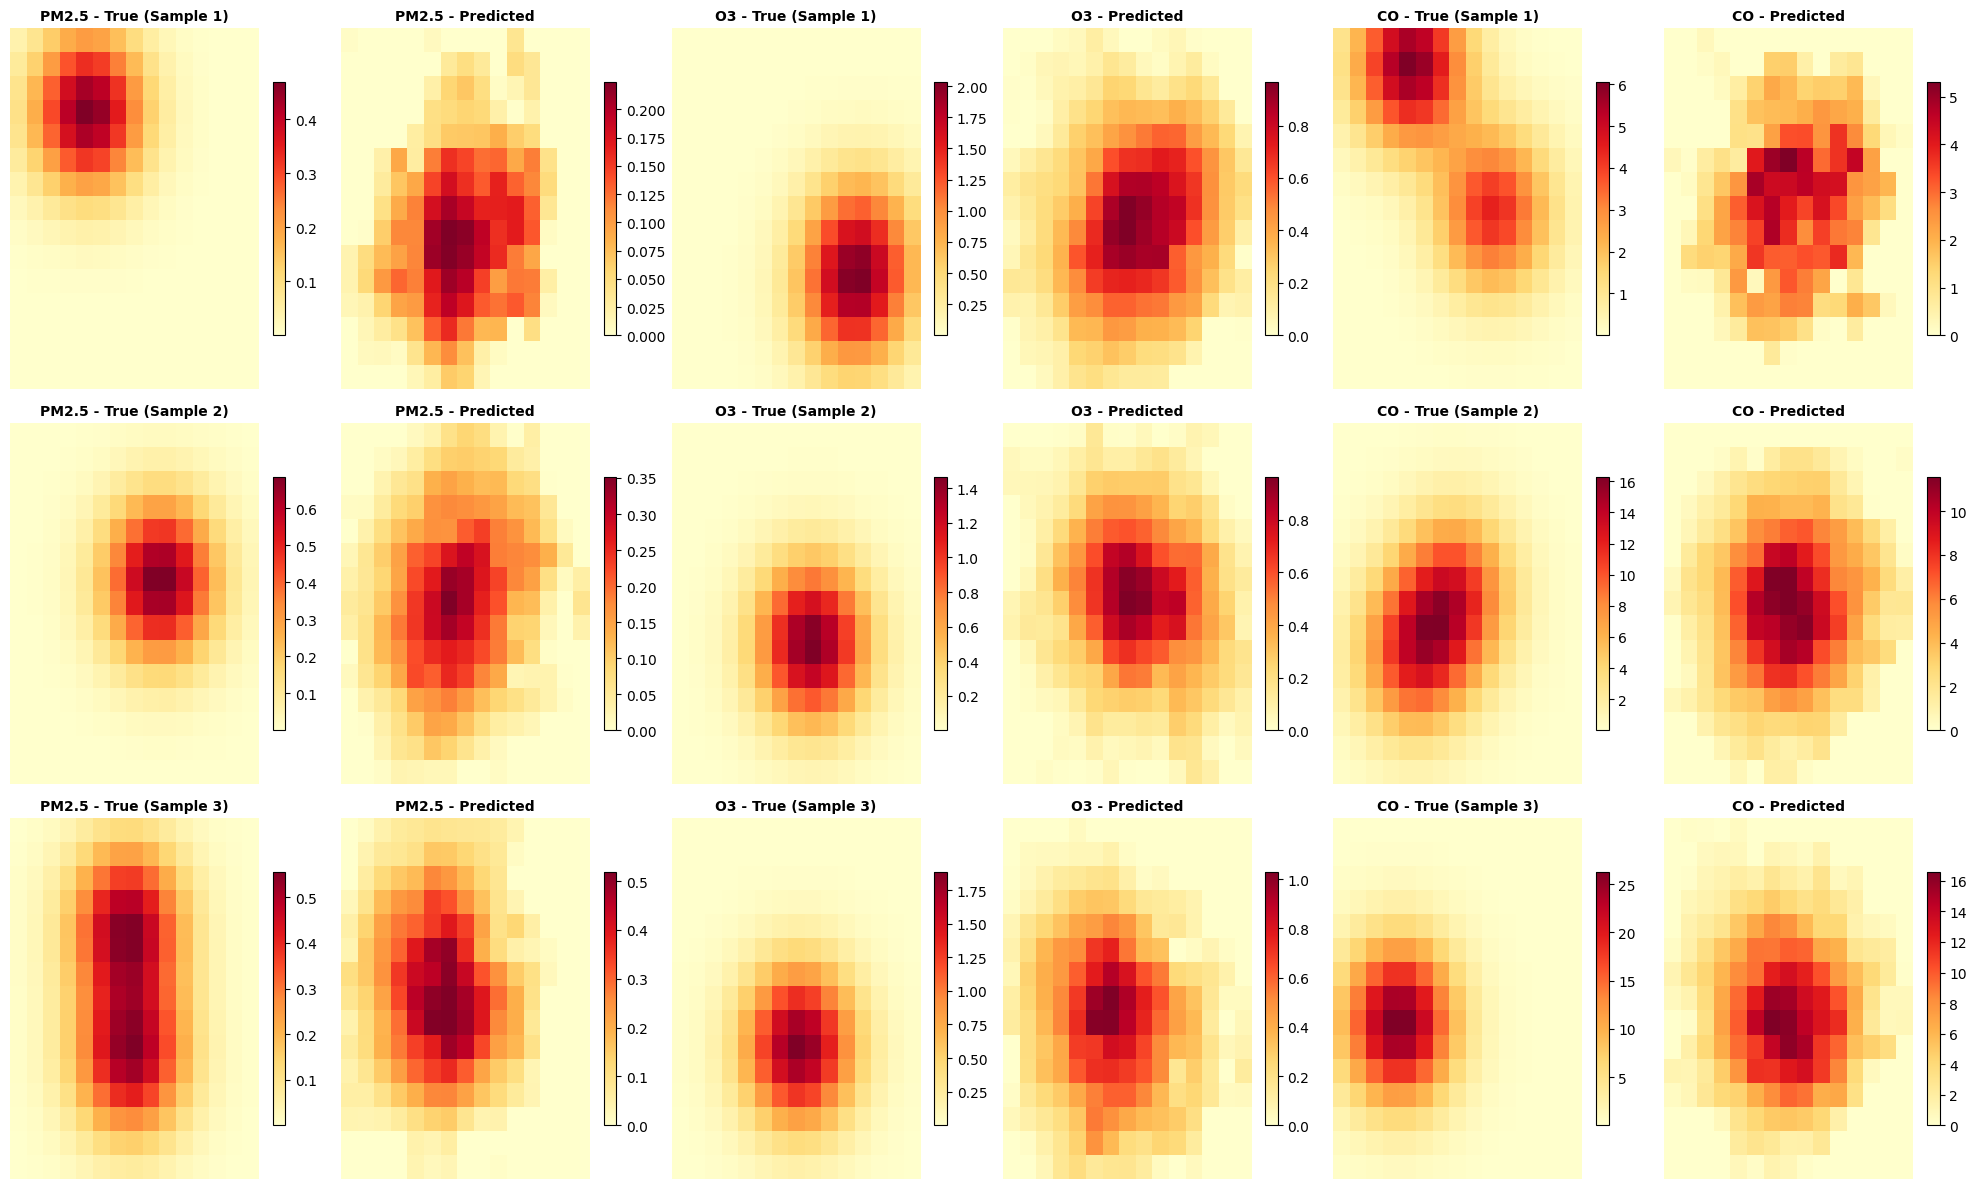

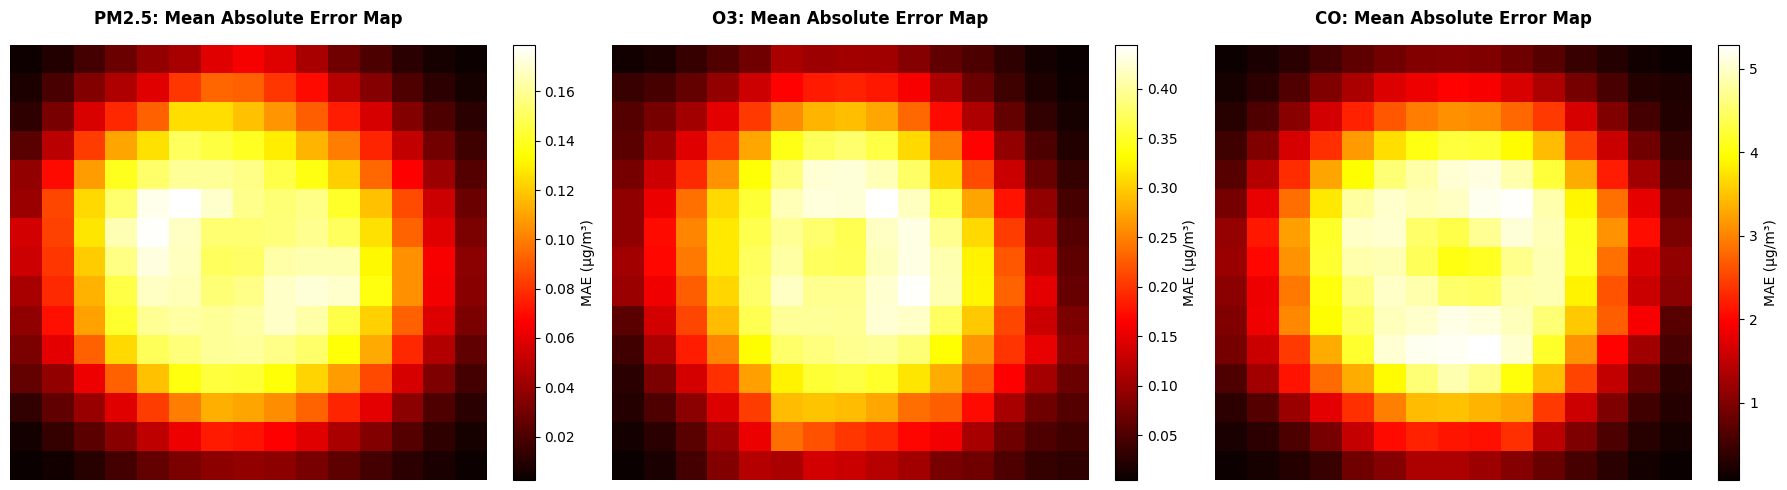


FINAL METRICS SUMMARY

Test Set Performance (Scalar):
Dataset Target       MAE      RMSE       R²     MAPE
   Test  PM2.5  1.112980  1.299156 0.966088 5.044192
   Test     O3  2.110040  2.666436 0.944392 3.663236
   Test     CO 30.485901 35.866913 0.977170 4.340755

✅ ALL CNN TRAINING & VISUALIZATIONS COMPLETED!

All results saved to: /content/results/cnn_multihead_fixed

Generated files:
  - cnn_training_history.png
  - cnn_metrics_comparison.png
  - cnn_actual_vs_predicted.png
  - cnn_residuals.png
  - cnn_error_distribution.png
  - cnn_heatmap_samples.png
  - cnn_heatmap_error_maps.png
  - best_cnn.keras (model)
  - predictions.pkl
  - evaluation_results.pkl
  - metrics.pkl


In [ ]:
# cnn_multihead_fixed_with_visualization.py
import os
import json
import math
import joblib
import logging
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                            f1_score, precision_score, recall_score,
                            confusion_matrix, classification_report)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
logger = logging.getLogger("cnn_multihead_fixed_viz")

# Set style
plt.style.use('default')
sns.set_palette("husl")

# ============================================================================
# CONFIG
# ============================================================================
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

BASE_DIR = Path("/content/results")
SHARED_DIR = BASE_DIR / "shared_data"
OUT_DIR = BASE_DIR / "cnn_multihead_fixed"
OUT_DIR.mkdir(parents=True, exist_ok=True)

GRID_SIZE = 15
N_CHANNELS = 7
N_POLLUTANTS = 3
BATCH_SIZE = 16
EPOCHS = 120

CHANNEL_COLS = [
    'pm2_5 (μg/m³)_mean', 'ozone (μg/m³)_mean',
    'carbon_monoxide (μg/m³)_mean', 'temp',
    'humidity', 'windspeed', 'cloudcover'
]
TARGET_COLS = ['pm2_5 (μg/m³)_mean', 'ozone (μg/m³)_mean', 'carbon_monoxide (μg/m³)_mean']
POLLUTANT_NAMES = ["PM2.5", "O3", "CO"]
COLORS = ['#E74C3C', '#3498DB', '#2ECC71']

# ============================================================================
# LOAD DATA
# ============================================================================
logger.info("Loading data from %s", SHARED_DIR)
train_df = joblib.load(SHARED_DIR / "train.pkl")
val_df   = joblib.load(SHARED_DIR / "val.pkl")
test_df  = joblib.load(SHARED_DIR / "test.pkl")
logger.info("Loaded: train=%d, val=%d, test=%d", len(train_df), len(val_df), len(test_df))

# ============================================================================
# HELPERS
# ============================================================================
def gaussian_kernel(grid_size, sigma=2.5, center=(0.0, 0.0)):
    """Generate Gaussian kernel for spatial distribution"""
    x, y = np.meshgrid(np.linspace(-1, 1, grid_size), np.linspace(-1, 1, grid_size))
    cx, cy = center
    distance = np.sqrt((x - cx)**2 + (y - cy)**2)
    sigma_coord = max(1e-6, sigma / (grid_size / 2.0))
    kernel = np.exp(-(distance**2) / (2 * (sigma_coord**2) + 1e-9))
    return kernel / (kernel.sum() + 1e-9)

def build_inputs_and_targets(df, add_spatial_variation=True):
    """Build grid inputs and targets (scalar + heatmap)"""
    X_list, Yreg_list, Ymap_list = [], [], []

    for _, row in df.iterrows():
        # Input grid
        grid = np.zeros((GRID_SIZE, GRID_SIZE, N_CHANNELS), dtype=np.float32)
        for ch_idx, col in enumerate(CHANNEL_COLS):
            base = float(row[col]) if (col in row.index and pd.notna(row[col])) else 0.0

            if add_spatial_variation:
                if col in ['pm2_5 (μg/m³)_mean', 'carbon_monoxide (μg/m³)_mean']:
                    # Pollutant sources with random centers
                    center = (np.random.normal(0, 0.3), np.random.normal(0, 0.3))
                    kernel = gaussian_kernel(GRID_SIZE, sigma=2.5, center=center)
                    variation = kernel * base * 0.5
                elif col == 'windspeed':
                    # Wind pattern (directional)
                    x = np.linspace(-1, 1, GRID_SIZE)
                    wind_pattern = np.outer(x, np.ones(GRID_SIZE))
                    variation = wind_pattern * base * 0.15
                else:
                    # Small random variation for other features
                    variation = np.random.normal(0, max(1e-6, abs(base) * 0.1),
                                                (GRID_SIZE, GRID_SIZE))
                grid[:, :, ch_idx] = np.maximum(base + variation, 0.0)
            else:
                grid[:, :, ch_idx] = np.maximum(base, 0.0)

        X_list.append(grid)

        # Scalar regression targets (raw values)
        y_reg = np.array([float(row[t]) if (t in row.index and pd.notna(row[t]))
                         else 0.0 for t in TARGET_COLS], dtype=np.float32)
        Yreg_list.append(y_reg)

        # Heatmap targets (spatialized from scalar)
        y_map = np.zeros((GRID_SIZE, GRID_SIZE, N_POLLUTANTS), dtype=np.float32)
        for p_idx, tcol in enumerate(TARGET_COLS):
            val = float(row[tcol]) if (tcol in row.index and pd.notna(row[tcol])) else 0.0
            # Create 1-2 pollution sources
            num_sources = np.random.choice([1, 2], p=[0.7, 0.3])
            accum = np.zeros((GRID_SIZE, GRID_SIZE), dtype=np.float32)
            for _ in range(num_sources):
                center = (np.random.normal(0, 0.3), np.random.normal(0, 0.3))
                accum += gaussian_kernel(GRID_SIZE, sigma=2.5, center=center) * (val / num_sources)
            y_map[:, :, p_idx] = np.maximum(accum, 0.0)

        Ymap_list.append(y_map)

    return np.array(X_list), np.array(Yreg_list), np.array(Ymap_list)

# ============================================================================
# BUILD DATA
# ============================================================================
logger.info("Building input grids and targets...")
X_train, Yreg_train, Ymap_train = build_inputs_and_targets(train_df)
X_val, Yreg_val, Ymap_val = build_inputs_and_targets(val_df)
X_test, Yreg_test, Ymap_test = build_inputs_and_targets(test_df)
logger.info("Shapes: X_train=%s, Yreg_train=%s, Ymap_train=%s",
           X_train.shape, Yreg_train.shape, Ymap_train.shape)

# ============================================================================
# PREPROCESSING
# ============================================================================
logger.info("Preprocessing data...")

# Scale input features using RobustScaler (better for outliers)
scaler_X = RobustScaler()
X_train_flat = X_train.reshape(-1, N_CHANNELS)
X_train_flat_s = scaler_X.fit_transform(X_train_flat)
X_train = X_train_flat_s.reshape(X_train.shape).astype(np.float32)
X_val = scaler_X.transform(X_val.reshape(-1, N_CHANNELS)).reshape(X_val.shape).astype(np.float32)
X_test = scaler_X.transform(X_test.reshape(-1, N_CHANNELS)).reshape(X_test.shape).astype(np.float32)

# Transform CO using log1p (consistent with GRU approach)
Yreg_train_tf = Yreg_train.copy()
Yreg_val_tf = Yreg_val.copy()
Yreg_test_tf = Yreg_test.copy()

# Winsorize CO before log transform
co_vals = Yreg_train[:, 2]
p_low, p_high = np.percentile(co_vals, [1, 99])
logger.info("CO winsorize thresholds: [%.2f, %.2f]", p_low, p_high)

Yreg_train_tf[:, 2] = np.clip(Yreg_train_tf[:, 2], p_low, p_high)
Yreg_val_tf[:, 2] = np.clip(Yreg_val_tf[:, 2], p_low, p_high)
Yreg_test_tf[:, 2] = np.clip(Yreg_test_tf[:, 2], p_low, p_high)

Yreg_train_tf[:, 2] = np.log1p(Yreg_train_tf[:, 2])
Yreg_val_tf[:, 2] = np.log1p(Yreg_val_tf[:, 2])
Yreg_test_tf[:, 2] = np.log1p(Yreg_test_tf[:, 2])

# Scale scalar targets
scaler_yreg = RobustScaler()
Yreg_train_s = scaler_yreg.fit_transform(Yreg_train_tf).astype(np.float32)
Yreg_val_s = scaler_yreg.transform(Yreg_val_tf).astype(np.float32)
Yreg_test_s = scaler_yreg.transform(Yreg_test_tf).astype(np.float32)

# Scale heatmaps (normalize by max per channel)
y_map_max = np.maximum(Ymap_train.max(axis=(0, 1, 2)), 1e-6)
Ymap_train_s = (Ymap_train / y_map_max.reshape((1, 1, 1, N_POLLUTANTS))).astype(np.float32)
Ymap_val_s = (Ymap_val / y_map_max.reshape((1, 1, 1, N_POLLUTANTS))).astype(np.float32)
Ymap_test_s = (Ymap_test / y_map_max.reshape((1, 1, 1, N_POLLUTANTS))).astype(np.float32)

# Save scalers
joblib.dump(scaler_X, OUT_DIR / "scaler_X.pkl")
joblib.dump(scaler_yreg, OUT_DIR / "scaler_yreg.pkl")
joblib.dump(y_map_max, OUT_DIR / "y_map_max.pkl")
joblib.dump({'p_low': p_low, 'p_high': p_high}, OUT_DIR / "co_transform_params.pkl")

logger.info("✅ Preprocessing complete")

# ============================================================================
# MODEL ARCHITECTURE
# ============================================================================
def build_multihead_cnn(grid_size=GRID_SIZE, in_channels=N_CHANNELS, out_channels=N_POLLUTANTS):
    """Enhanced CNN with encoder-decoder for heatmap + regression branch"""
    inp = keras.Input(shape=(grid_size, grid_size, in_channels), name="input_grid")

    # Encoder
    x = layers.Conv2D(32, 3, padding='same', activation='relu',
                     kernel_regularizer=regularizers.l2(0.001))(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu',
                     kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.SpatialDropout2D(0.2)(x)

    x = layers.Conv2D(128, 3, padding='same', activation='relu',
                     kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.SpatialDropout2D(0.25)(x)

    # Bottleneck
    x = layers.Conv2D(256, 3, padding='same', activation='relu',
                     kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)

    # Heatmap decoder branch
    h = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    h = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(h)
    h = layers.BatchNormalization()(h)
    h = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(h)
    h = layers.BatchNormalization()(h)
    h = layers.Resizing(grid_size, grid_size, interpolation='bilinear')(h)
    heatmap_out = layers.Conv2D(out_channels, 1, padding='same', activation='relu',
                                name='heatmap_out')(h)

    # Regression branch (scalar)
    r = layers.GlobalAveragePooling2D()(x)
    r = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(r)
    r = layers.Dropout(0.35)(r)
    r = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(r)
    r = layers.Dropout(0.3)(r)
    reg_out = layers.Dense(out_channels, activation='linear', name='reg_out')(r)

    model = keras.Model(inp, outputs=[reg_out, heatmap_out], name="cnn_multihead")
    return model

model = build_multihead_cnn()

# Custom weighted loss for regression (emphasize CO)
def weighted_reg_loss(y_true, y_pred):
    weights = tf.constant([1.0, 1.0, 2.5], dtype=tf.float32)
    squared_error = tf.square(y_true - y_pred) * weights
    return tf.reduce_mean(tf.reduce_sum(squared_error, axis=-1))

# Compile
opt = keras.optimizers.Adam(learning_rate=5e-4, clipnorm=1.0)
model.compile(
    optimizer=opt,
    loss={'reg_out': weighted_reg_loss, 'heatmap_out': 'huber'},
    loss_weights={'reg_out': 1.0, 'heatmap_out': 1.0},
    metrics={}
)
model.summary()

# ============================================================================
# CALLBACKS
# ============================================================================
ckpt_path = OUT_DIR / "best_cnn.keras"
mc = callbacks.ModelCheckpoint(str(ckpt_path), monitor='val_loss',
                               save_best_only=True, verbose=1)
es = callbacks.EarlyStopping(monitor='val_loss', patience=25,
                            restore_best_weights=True, verbose=1)
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10,
                                 factor=0.5, min_lr=1e-7, verbose=1)

# ============================================================================
# TRAINING
# ============================================================================
logger.info("Training model...")
history = model.fit(
    X_train,
    {'reg_out': Yreg_train_s, 'heatmap_out': Ymap_train_s},
    validation_data=(X_val, {'reg_out': Yreg_val_s, 'heatmap_out': Ymap_val_s}),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[mc, es, rlr],
    verbose=1
)

# Save history
joblib.dump(history.history, OUT_DIR / "history.pkl")
logger.info("✅ Training complete")

# ============================================================================
# PREDICTION & INVERSE TRANSFORM
# ============================================================================
logger.info("Making predictions...")

def predict_and_inverse(model, X, Yreg_orig, scaler_yreg, y_map_max):
    """Predict and inverse transform predictions"""
    pred_reg_s, pred_map_s = model.predict(X, verbose=0)

    # Inverse scalar predictions
    pred_reg_tf = scaler_yreg.inverse_transform(pred_reg_s)
    pred_reg = pred_reg_tf.copy()
    pred_reg[:, 2] = np.expm1(pred_reg_tf[:, 2])  # Inverse log1p for CO
    pred_reg = np.clip(pred_reg, 0.0, None)

    # Inverse heatmap predictions
    pred_map = np.clip(pred_map_s, 0.0, 1.0) * y_map_max.reshape((1, 1, 1, N_POLLUTANTS))
    pred_map = np.clip(pred_map, 0.0, None)

    return pred_reg, pred_map

# Predictions for all sets
pred_train_reg, pred_train_map = predict_and_inverse(model, X_train, Yreg_train, scaler_yreg, y_map_max)
pred_val_reg, pred_val_map = predict_and_inverse(model, X_val, Yreg_val, scaler_yreg, y_map_max)
pred_test_reg, pred_test_map = predict_and_inverse(model, X_test, Yreg_test, scaler_yreg, y_map_max)

# Save predictions
joblib.dump({
    'train': {'reg': pred_train_reg, 'map': pred_train_map},
    'val': {'reg': pred_val_reg, 'map': pred_val_map},
    'test': {'reg': pred_test_reg, 'map': pred_test_map}
}, OUT_DIR / "predictions.pkl")

# ============================================================================
# EVALUATION FUNCTIONS
# ============================================================================
def calculate_metrics(y_true, y_pred, pollutant_name):
    """Calculate regression metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # MAPE with threshold
    mask = y_true > 1e-3
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = float('nan')

    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape}

def evaluate_set(y_true_reg, y_pred_reg, y_true_map, y_pred_map, set_name):
    """Evaluate both scalar and heatmap predictions"""
    results = {'scalar': {}, 'heatmap': {}}

    print(f"\n{'='*70}")
    print(f"{set_name} SET - SCALAR REGRESSION")
    print('='*70)

    for i, name in enumerate(POLLUTANT_NAMES):
        metrics = calculate_metrics(y_true_reg[:, i], y_pred_reg[:, i], name)
        results['scalar'][name] = metrics
        results['scalar'][name]['y_true'] = y_true_reg[:, i]
        results['scalar'][name]['y_pred'] = y_pred_reg[:, i]

        print(f"{name:<8} -> MAE: {metrics['MAE']:.4f} | RMSE: {metrics['RMSE']:.4f} | "
              f"R²: {metrics['R2']:.4f} | MAPE: {metrics['MAPE']:.2f}%")

    print(f"\n{'='*70}")
    print(f"{set_name} SET - HEATMAP REGRESSION (Pixel-wise)")
    print('='*70)

    for i, name in enumerate(POLLUTANT_NAMES):
        y_t = y_true_map[..., i].ravel()
        y_p = y_pred_map[..., i].ravel()
        metrics = calculate_metrics(y_t, y_p, name)
        results['heatmap'][name] = metrics

        print(f"{name:<8} -> MAE: {metrics['MAE']:.4f} | RMSE: {metrics['RMSE']:.4f} | "
              f"R²: {metrics['R2']:.4f} | MAPE: {metrics['MAPE']:.2f}%")

    return results

# Evaluate all sets
results_train = evaluate_set(Yreg_train, pred_train_reg, Ymap_train, pred_train_map, "TRAIN")
results_val = evaluate_set(Yreg_val, pred_val_reg, Ymap_val, pred_val_map, "VALIDATION")
results_test = evaluate_set(Yreg_test, pred_test_reg, Ymap_test, pred_test_map, "TEST")

# Overfitting check
train_r2_mean = np.mean([results_train['scalar'][p]['R2'] for p in POLLUTANT_NAMES])
test_r2_mean = np.mean([results_test['scalar'][p]['R2'] for p in POLLUTANT_NAMES])
gap = train_r2_mean - test_r2_mean

print(f"\n{'='*70}")
print("OVERFITTING CHECK")
print('='*70)
print(f"Train mean R²: {train_r2_mean:.4f}")
print(f"Test mean R²:  {test_r2_mean:.4f}")
print(f"Gap:           {gap:.4f} ({gap*100:.2f}%)")

# Save results
all_results = {
    'train': results_train,
    'val': results_val,
    'test': results_test,
    'overfitting_gap': gap
}
joblib.dump(all_results, OUT_DIR / "evaluation_results.pkl")

# Create metrics dataframe
metrics_list = []
for set_name, results in [('Train', results_train), ('Validation', results_val), ('Test', results_test)]:
    for pollutant in POLLUTANT_NAMES:
        metrics_list.append({
            'Dataset': set_name,
            'Target': pollutant,
            'MAE': results['scalar'][pollutant]['MAE'],
            'RMSE': results['scalar'][pollutant]['RMSE'],
            'R²': results['scalar'][pollutant]['R2'],
            'MAPE': results['scalar'][pollutant]['MAPE']
        })

metrics_df = pd.DataFrame(metrics_list)
joblib.dump(metrics_df, OUT_DIR / "metrics.pkl")

# ============================================================================
# VISUALIZATIONS
# ============================================================================
logger.info("Creating visualizations...")

# 1. Training History
fig1 = plt.figure(figsize=(16, 5))

ax1 = plt.subplot(1, 3, 1)
ax1.plot(history.history['loss'], label='Train Loss', linewidth=2, color='#3498DB')
ax1.plot(history.history['val_loss'], label='Val Loss', linewidth=2, color='#E74C3C')
ax1.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax1.set_ylabel('Total Loss', fontsize=11, fontweight='bold')
ax1.set_title('Training & Validation Loss', fontsize=12, fontweight='bold', pad=15)
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

ax2 = plt.subplot(1, 3, 2)
ax2.plot(history.history['reg_out_loss'], label='Scalar Loss (Train)', linewidth=2, color='#9B59B6')
ax2.plot(history.history['val_reg_out_loss'], label='Scalar Loss (Val)', linewidth=2, color='#E67E22')
ax2.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax2.set_ylabel('Scalar Regression Loss', fontsize=11, fontweight='bold')
ax2.set_title('Scalar Branch Loss', fontsize=12, fontweight='bold', pad=15)
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

ax3 = plt.subplot(1, 3, 3)
ax3.plot(history.history['heatmap_out_loss'], label='Heatmap Loss (Train)', linewidth=2, color='#1ABC9C')
ax3.plot(history.history['val_heatmap_out_loss'], label='Heatmap Loss (Val)', linewidth=2, color='#34495E')
ax3.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax3.set_ylabel('Heatmap Loss', fontsize=11, fontweight='bold')
ax3.set_title('Heatmap Branch Loss', fontsize=12, fontweight='bold', pad=15)
ax3.legend(fontsize=10)
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUT_DIR / 'cnn_training_history.png', dpi=300, bbox_inches='tight')
logger.info("✅ Saved: cnn_training_history.png")
plt.show()

# 2. Metrics Comparison
fig2 = plt.figure(figsize=(18, 12))

# R² by pollutant
ax1 = plt.subplot(2, 2, 1)
test_r2 = [results_test['scalar'][p]['R2'] for p in POLLUTANT_NAMES]
bars = ax1.bar(range(len(POLLUTANT_NAMES)), test_r2, color=COLORS, alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_xticks(range(len(POLLUTANT_NAMES)))
ax1.set_xticklabels(POLLUTANT_NAMES)
ax1.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax1.set_title('R² Score by Pollutant (Test Set)', fontsize=13, fontweight='bold', pad=15)
ax1.set_ylim([0, 1.0])
ax1.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, test_r2):
    ax1.text(bar.get_x() + bar.get_width()/2., val + 0.02, f'{val:.4f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# RMSE comparison
ax2 = plt.subplot(2, 2, 2)
datasets = ['Train', 'Validation', 'Test']
x = np.arange(len(datasets))
width = 0.25
for i, (name, color) in enumerate(zip(POLLUTANT_NAMES, COLORS)):
    rmse_vals = [
        results_train['scalar'][name]['RMSE'],
        results_val['scalar'][name]['RMSE'],
        results_test['scalar'][name]['RMSE']
    ]
    ax2.bar(x + i*width, rmse_vals, width, label=name, color=color, alpha=0.8)
ax2.set_xlabel('Dataset', fontsize=12, fontweight='bold')
ax2.set_ylabel('RMSE', fontsize=12, fontweight='bold')
ax2.set_title('RMSE Across Datasets', fontsize=13, fontweight='bold', pad=15)
ax2.set_xticks(x + width)
ax2.set_xticklabels(datasets)
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# MAPE comparison
ax3 = plt.subplot(2, 2, 3)
for name, color in zip(POLLUTANT_NAMES, COLORS):
    mape_vals = [
        results_train['scalar'][name]['MAPE'],
        results_val['scalar'][name]['MAPE'],
        results_test['scalar'][name]['MAPE']
    ]
    ax3.plot(datasets, mape_vals, 'o-', label=name, color=color, linewidth=2.5, markersize=8)
ax3.set_ylabel('MAPE (%)', fontsize=12, fontweight='bold')
ax3.set_title('MAPE Across Datasets', fontsize=13, fontweight='bold', pad=15)
ax3.legend(fontsize=10)
ax3.grid(alpha=0.3)

# Overfitting check
ax4 = plt.subplot(2, 2, 4)
for name, color in zip(POLLUTANT_NAMES, COLORS):
    train_r2 = results_train['scalar'][name]['R2']
    test_r2 = results_test['scalar'][name]['R2']
    ax4.plot(['Train', 'Test'], [train_r2, test_r2], 'o-', label=name,
            color=color, linewidth=2.5, markersize=10)
ax4.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax4.set_title('Overfitting Check: Train vs Test R²', fontsize=13, fontweight='bold', pad=15)
ax4.legend(fontsize=11)
ax4.grid(alpha=0.3)
ax4.set_ylim([0, 1.0])

plt.tight_layout()
plt.savefig(OUT_DIR / 'cnn_metrics_comparison.png', dpi=300, bbox_inches='tight')
logger.info("✅ Saved: cnn_metrics_comparison.png")
plt.show()

# 3. Actual vs Predicted (Scalar)
fig3 = plt.figure(figsize=(18, 5))

for i, (name, color) in enumerate(zip(POLLUTANT_NAMES, COLORS)):
    ax = plt.subplot(1, 3, i+1)

    y_true = results_test['scalar'][name]['y_true']
    y_pred = results_test['scalar'][name]['y_pred']

    ax.scatter(y_true, y_pred, alpha=0.6, s=60, color=color, edgecolors='k', linewidth=0.5)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
           'r--', lw=2.5, label='Perfect Prediction')

    ax.set_xlabel(f'Actual {name} (μg/m³)', fontsize=11, fontweight='bold')
    ax.set_ylabel(f'Predicted {name} (μg/m³)', fontsize=11, fontweight='bold')
    ax.set_title(f'{name}: Actual vs Predicted', fontsize=12, fontweight='bold', pad=15)
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

    metrics = results_test['scalar'][name]
    textstr = f"R² = {metrics['R2']:.4f}\nRMSE = {metrics['RMSE']:.4f}\nMAPE = {metrics['MAPE']:.2f}%"
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
           verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig(OUT_DIR / 'cnn_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
logger.info("✅ Saved: cnn_actual_vs_predicted.png")
plt.show()

# 4. Residual Analysis
fig4 = plt.figure(figsize=(18, 5))

for i, (name, color) in enumerate(zip(POLLUTANT_NAMES, COLORS)):
    ax = plt.subplot(1, 3, i+1)

    y_true = results_test['scalar'][name]['y_true']
    y_pred = results_test['scalar'][name]['y_pred']
    residuals = y_true - y_pred

    ax.scatter(y_pred, residuals, alpha=0.6, s=60, color=color, edgecolors='k', linewidth=0.5)
    ax.axhline(y=0, color='r', linestyle='--', linewidth=2.5, label='Zero Error')

    ax.set_xlabel(f'Predicted {name} (μg/m³)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Residuals (μg/m³)', fontsize=11, fontweight='bold')
    ax.set_title(f'{name}: Residual Plot', fontsize=12, fontweight='bold', pad=15)
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

    mean_res = np.mean(residuals)
    std_res = np.std(residuals)
    textstr = f'Mean: {mean_res:.4f}\nStd: {std_res:.4f}'
    props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
           verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig(OUT_DIR / 'cnn_residuals.png', dpi=300, bbox_inches='tight')
logger.info("✅ Saved: cnn_residuals.png")
plt.show()

# 5. Error Distribution
fig5 = plt.figure(figsize=(18, 5))

for i, (name, color) in enumerate(zip(POLLUTANT_NAMES, COLORS)):
    ax = plt.subplot(1, 3, i+1)

    y_true = results_test['scalar'][name]['y_true']
    y_pred = results_test['scalar'][name]['y_pred']
    errors = y_true - y_pred

    ax.hist(errors, bins=30, alpha=0.7, color=color, edgecolor='black', linewidth=1.2)
    ax.axvline(x=0, color='r', linestyle='--', linewidth=2.5, label='Zero Error')

    ax.set_xlabel(f'Prediction Error (μg/m³)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title(f'{name}: Error Distribution', fontsize=12, fontweight='bold', pad=15)
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)

    mean_err = np.mean(errors)
    std_err = np.std(errors)
    textstr = f'Mean: {mean_err:.4f}\nStd: {std_err:.4f}'
    props = dict(boxstyle='round', facecolor='lightgreen', alpha=0.8)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
           verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig(OUT_DIR / 'cnn_error_distribution.png', dpi=300, bbox_inches='tight')
logger.info("✅ Saved: cnn_error_distribution.png")
plt.show()

# 6. Heatmap Samples
fig6 = plt.figure(figsize=(20, 12))

sample_indices = np.random.choice(len(test_df), 3, replace=False)

for idx, sample_idx in enumerate(sample_indices):
    for p_idx, (name, color) in enumerate(zip(POLLUTANT_NAMES, COLORS)):
        # True heatmap
        ax1 = plt.subplot(3, 6, idx*6 + p_idx*2 + 1)
        im1 = ax1.imshow(Ymap_test[sample_idx, :, :, p_idx], cmap='YlOrRd', aspect='auto')
        ax1.set_title(f'{name} - True (Sample {idx+1})', fontsize=10, fontweight='bold')
        ax1.axis('off')
        plt.colorbar(im1, ax=ax1, fraction=0.046)

        # Predicted heatmap
        ax2 = plt.subplot(3, 6, idx*6 + p_idx*2 + 2)
        im2 = ax2.imshow(pred_test_map[sample_idx, :, :, p_idx], cmap='YlOrRd', aspect='auto')
        ax2.set_title(f'{name} - Predicted', fontsize=10, fontweight='bold')
        ax2.axis('off')
        plt.colorbar(im2, ax=ax2, fraction=0.046)

plt.tight_layout()
plt.savefig(OUT_DIR / 'cnn_heatmap_samples.png', dpi=300, bbox_inches='tight')
logger.info("✅ Saved: cnn_heatmap_samples.png")
plt.show()

# 7. Heatmap Error Maps
fig7 = plt.figure(figsize=(18, 5))

for p_idx, name in enumerate(POLLUTANT_NAMES):
    ax = plt.subplot(1, 3, p_idx+1)

    # Calculate mean absolute error map
    error_map = np.mean(np.abs(Ymap_test[:, :, :, p_idx] - pred_test_map[:, :, :, p_idx]), axis=0)

    im = ax.imshow(error_map, cmap='hot', aspect='auto')
    ax.set_title(f'{name}: Mean Absolute Error Map', fontsize=12, fontweight='bold', pad=15)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, label='MAE (μg/m³)')

plt.tight_layout()
plt.savefig(OUT_DIR / 'cnn_heatmap_error_maps.png', dpi=300, bbox_inches='tight')
logger.info("✅ Saved: cnn_heatmap_error_maps.png")
plt.show()

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*70)
print("FINAL METRICS SUMMARY")
print("="*70)
print("\nTest Set Performance (Scalar):")
print(metrics_df[metrics_df['Dataset'] == 'Test'].to_string(index=False))

print("\n" + "="*70)
print("✅ ALL CNN TRAINING & VISUALIZATIONS COMPLETED!")
print("="*70)
print(f"\nAll results saved to: {OUT_DIR}")
print("\nGenerated files:")
print("  - cnn_training_history.png")
print("  - cnn_metrics_comparison.png")
print("  - cnn_actual_vs_predicted.png")
print("  - cnn_residuals.png")
print("  - cnn_error_distribution.png")
print("  - cnn_heatmap_samples.png")
print("  - cnn_heatmap_error_maps.png")
print("  - best_cnn.keras (model)")
print("  - predictions.pkl")
print("  - evaluation_results.pkl")
print("  - metrics.pkl")

# Save metadata
metadata = {
    'model': 'CNN Multi-Head (Regression + Heatmap)',
    'grid_size': GRID_SIZE,
    'n_channels': N_CHANNELS,
    'n_pollutants': N_POLLUTANTS,
    'pollutant_names': POLLUTANT_NAMES,
    'batch_size': BATCH_SIZE,
    'epochs_trained': len(history.history['loss']),
    'train_samples': len(train_df),
    'val_samples': len(val_df),
    'test_samples': len(test_df),
    'overfitting_gap': float(gap),
    'test_metrics': {
        name: {
            'MAE': float(results_test['scalar'][name]['MAE']),
            'RMSE': float(results_test['scalar'][name]['RMSE']),
            'R2': float(results_test['scalar'][name]['R2']),
            'MAPE': float(results_test['scalar'][name]['MAPE'])
        } for name in POLLUTANT_NAMES
    }
}
joblib.dump(metadata, OUT_DIR / "metadata.pkl")
logger.info("✅ Metadata saved")

logger.info("\n🎉 CNN Multi-Head Training & Evaluation Complete!")

In [ ]:
from google.colab import files
import shutil

# folder yang ingin di-download
path_folder = "/content/results"
# nama file zip output
zip_name = "results.zip"

# membuat zip
shutil.make_archive("results", 'zip', path_folder)

# download zip
files.download(zip_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>